In [ ]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

import seaborn as sns
from osgeo import gdal
import numpy.ma as ma
import geopandas as gpd
import rasterio as rio
import shapely
import os
import shutil, os
from rasterio.plot import show
from rasterio.warp import calculate_default_transform, reproject, Resampling

sns.set(font_scale=1.35, style='whitegrid')
%config Completer.use_jedi = False

In [ ]:

Shape_file_path_California = '/Users/lamaelhalabi/Documents/research Berekely /Lamas processing code/Maps/My Data'

# Data processing of ASO files


Reprojection Function

Running gdal.Info() above on the sample ASO and PRISM file shows us that the PRISM data and ASO are in different coordinate systems. This is why the x-ticks and y-ticks for the two datasets were different when plotted above using rasterio.plot.show

Before we can compare the two datasets, we need to ensure that the coordinate systems are consistent. The PRISM data are in a geographic coordinate system, while the ASO data are in a projected coordinate system.

Commonly used coordinate systems have an "EPSG" code associated with them (https://en.wikipedia.org/wiki/EPSG_Geodetic_Parameter_Dataset). The EPSG code corresponding to the PRISM data is EPSG:4269.

In [ ]:
def reproject_raster(src_file, dst_file, dst_crs = 'EPSG:4269'):
    """Reproject the src_file to a coordinate system specified by dst_crs.
    The result in stored in dst_file. EPSG:4269 corresponds to the coordinate
    system employed by PRISM.
    Source: https://rasterio.readthedocs.io/en/latest/topics/reproject.html"""

    """calculate_default_transform(): transforms bounds to target coordinate system, calculates resolution if
    not provided, and returns destination transform and dimensions."""

    with rio.open(src_file) as src:
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds)
        kwargs = src.meta.copy()   #here we are changing the metadata of src to match
        kwargs.update({
            'crs': dst_crs,
            'transform': transform,
            'width': width,
            'height': height
        })

        with rio.open(dst_file, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1): #for all 'pixels' in src_file ?
                reproject(
                    source=rio.band(src, i),
                    destination=rio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest)
    return

Aggregatation functions for upscaling


In [ ]:
def aggregate2x2(src_array):
    """This function upscales src_array by a factor of 2. Specifically, it uses a 2x2 kernel
    (with a stride of 2) and average pools the src_array.
    """
    src_array = make_shape_even(src_array) # what is this for?
    #a.shape = np.shape(a) = size of a (here why are we using indexing 1 and 0, arrange = arranges things in order
    agg_list = [[np.mean(src_array[row:row+2, col:col+2]) for col in np.arange(0,src_array.shape[1],2)] for row in np.arange(0,src_array.shape[0],2)]
    # here we are getting a list of the values of the mean values of 4 pixels to put to one
    #np.array creates array out of list
    agg_array = np.array(agg_list).reshape(src_array.shape[0]//2,src_array.shape[1]//2) #deviding the size
    return np.asarray(agg_array, dtype=src_array.dtype)


def make_shape_even(src_array):
    """This function ensures that the shape of a masked array is divisible 2.
    If not divisible by 2, this functions pads the borders with nan."""
    rows = src_array.shape[0]
    cols = src_array.shape[1]
    rows_dest = rows+1 if rows%2==1 else rows
    cols_dest = cols+1 if cols%2==1 else cols
    dst_array = np.empty((rows_dest,cols_dest))
    dst_array[:] = np.nan
    dst_array[:rows,:cols] = src_array.copy()
    return np.asarray(dst_array, dtype=src_array.dtype)

Function to save aggregated array. After aggregating, copy the meta information from the source file, and update the transform.

In [ ]:
def write_agg_geotif(template, agg_array, dst_filename):
    """Write the aggregated dataset. This assumes that the
    aggregated dataset upscales src by a factor of 2. For other
    factors, replace '2' by the actual factor."""

    transform = template.transform * template.transform.scale(2,2)
    width = int(np.ceil(template.width/2))
    height = int(np.ceil(template.height/2))
    kwargs = template.meta.copy()
    kwargs.update({
        'transform': transform,
        'width': width,
        'height': height
    })


    with rio.open(dst_filename, "w", **kwargs) as dest:
        dest.write(agg_array,1)
        dest.nodata = template.read(1, masked=True).fill_value

    return

Rescale PRISM and ASO grids


In [ ]:
def rescale_src_from_template(template_file, src_file, dst_file):
    """This function rescales the src_file raster to the resolution of the template_file raster.
    The rescaled src_file is stored in dst_file raster."""
    template = rio.open(template_file)
    src = rio.open(src_file)

    scale_factor = template.res[0]/src.res[0]

    src_transform = src.transform

    dst_transform = src.transform * src.transform.scale(scale_factor,scale_factor)
    height = int(src.meta['height']/scale_factor)
    width = int(src.meta['width']/scale_factor)

    data = src.read()

    kwargs = src.meta.copy()
    kwargs['transform'] = dst_transform
    kwargs['height'] = height
    kwargs['width'] = width
    kwargs['crs'] = template.crs
    src.close()


    with rio.open(dst_file, 'w', **kwargs) as dst:

        for i, band in enumerate(data, 1):
            dest = np.zeros((height, width), dtype=band.dtype)

            reproject(
                band,
                dest,
                src_transform=src_transform,
                src_crs=template.crs,
                src_nodata=-9999,
                dst_transform=dst_transform,
                dst_crs=template.crs,
                resampling=Resampling.bilinear)

            dst.write(dest, indexes=i)
    return

Align PRISM and ASO grids

In [ ]:
def get_Points_gdf(src_file):
    """This function reads in a raster, and obtains Long/Lat values of the center
    of each pixel. It returns a geodataframe."""
    raster = rio.open(src_file)
    arr = raster.read(1)
    indices = np.argwhere(~np.isnan(arr))

    coords = raster.xy(indices[:,0], indices[:,1])

    Points_gdf= gpd.GeoDataFrame({'Longitude':coords[0],'Latitude': coords[1]},
                                  geometry=[shapely.geometry.Point(x, y) for x, y in zip(coords[0], coords[1])])
    return Points_gdf



def translate_rescaled_src(template_file, src_file, rescaled_src_file, Points_gdf, dst_file):
    """This function rescales and translates the src_file raster so that the grid is perfectly
    aligned with the template_file raster grid. It uses the rescaled_src_file to determine how much
    translation is needed."""

    template = rio.open(template_file)
    rescaled_src = rio.open(rescaled_src_file)

    rc = rio.transform.rowcol(rescaled_src.transform, Points_gdf.Longitude[0], Points_gdf.Latitude[0])
    cr_coord = [item + 0.5 for item in reversed(rc)]

    pixel_coord = ~rescaled_src.transform*(Points_gdf.Longitude[0], Points_gdf.Latitude[0])
    pixel_coord = list(pixel_coord)

    offset_x = pixel_coord[0] - cr_coord[0]
    offset_y = pixel_coord[1] - cr_coord[1]



    with rio.open(src_file) as src:

        scale_factor = template.res[0]/src.res[0]

        src_transform = src.transform

        dst_transform = src.transform * src.transform.scale(scale_factor,scale_factor) * src.transform.translation(offset_x,offset_y)

        height = int(src.meta['height']/scale_factor)
        width = int(src.meta['width']/scale_factor)

        data = src.read()

        kwargs = src.meta.copy()
        kwargs['transform'] = dst_transform
        kwargs['height'] = height
        kwargs['width'] = width
        kwargs['crs'] = template.crs



        with rio.open(dst_file, 'w', **kwargs) as dst:

            for i, band in enumerate(data, 1):
                dest = np.zeros((height, width), dtype=band.dtype)

                reproject(
                    band,
                    dest,
                    src_transform=src_transform,
                    src_crs=template.crs,
                    src_nodata=-9999,
                    dst_transform=dst_transform,
                    dst_crs=template.crs,
                    resampling=Resampling.bilinear)

                dst.write(dest, indexes=i)

    return

In [ ]:
data_path = "/Users/lamaelhalabi/Documents/research Berekely /Lamas processing code/Maps"
data_dir = os.listdir(data_path)

ASO_files = []

for s in data_dir:  # for each folder in the directory
    if '.xml' not in s and 'ASO' in s and '.tif' in s: #remove the .xml files
        ASO_files.append(s)

ASO_files = sorted(ASO_files) #remove duplicate spatial extents
print(ASO_files)

['ASO_50M_SWE_USCACE_20160401.tif', 'ASO_50M_SWE_USCACE_20160407.tif', 'ASO_50M_SWE_USCACE_20160416.tif', 'ASO_50M_SWE_USCACE_20160426.tif', 'ASO_50M_SWE_USCACE_20160509.tif', 'ASO_50M_SWE_USCACE_20170129.tif', 'ASO_50M_SWE_USCACE_20170717.tif', 'ASO_50M_SWE_USCACE_20170727.tif', 'ASO_50M_SWE_USCACE_20170816.tif', 'ASO_50M_SWE_USCACE_20180423.tif', 'ASO_50M_SWE_USCACE_20180528.tif', 'ASO_50M_SWE_USCAJW_20180423.tif', 'ASO_50M_SWE_USCAJW_20180602.tif', 'ASO_50M_SWE_USCAJW_20190315.tif', 'ASO_50M_SWE_USCAJW_20190605.tif', 'ASO_50M_SWE_USCAKC_20180426.tif', 'ASO_50M_SWE_USCAKC_20190316.tif', 'ASO_50M_SWE_USCAKC_20190326.tif', 'ASO_50M_SWE_USCAKC_20190418.tif', 'ASO_50M_SWE_USCAKC_20190427.tif', 'ASO_50M_SWE_USCAKC_20190428.tif', 'ASO_50M_SWE_USCAKC_20190608.tif', 'ASO_50M_SWE_USCAKC_20190611.tif', 'ASO_50M_SWE_USCAKN_20180426.tif', 'ASO_50M_SWE_USCAKN_20190417.tif', 'ASO_50M_SWE_USCAKW_20190317.tif', 'ASO_50M_SWE_USCAKW_20190324.tif', 'ASO_50M_SWE_USCAKW_20190421.tif', 'ASO_50M_SWE_USCALB

This code reprojects and aggregates all ASO files creating 5 reprojected files at resolutions 50M, 100M, 200M, 400M, 800M.

In [ ]:
for ASO_file in ASO_files:

    # reproject ASO file
    ASO_file_reprojected = '50MReprojected' + ASO_file
    desired_crs = 'epsg:4269'
    reproject_raster(ASO_file, ASO_file_reprojected, desired_crs)

    #aggregate (4-5)
    dst_filename = '100' + ASO_file_reprojected[2 :]

    for i in range(4):
        src_raster = rio.open(ASO_file_reprojected)
        agg_array = aggregate2x2(src_raster.read(1, masked=True).filled(fill_value=np.nan))
        ASO_file_reprojected = dst_filename
        write_agg_geotif(src_raster, agg_array, dst_filename)
        src_raster.close()
        if i == 0:
            dst_filename = '200' + dst_filename[3 :]
        if i == 1:
            dst_filename = '400' + dst_filename[3 :]
        if i == 2:
            dst_filename = '800' + dst_filename[3 :]


In [ ]:
data_path = "/Users/lamaelhalabi/Documents/research Berekely /Lamas processing code/Maps/My Data"
data_dir = os.listdir(data_path)
# for each folder in the directory
ASO_files_50M = [] #create an empty list of ASO files
ASO_files_100M = []
ASO_files_200M = []
ASO_files_400M = []
ASO_files_800M = []

for s in data_dir:  #remove the .xml files

    if '50MReprojected' in s and '.tif' in s:
        ASO_files_50M.append(s)

    if '100MReprojected' in s and '.tif' in s:
        ASO_files_100M.append(s)

    if '200MReprojected' in s and '.tif' in s:
        ASO_files_200M.append(s)

    if '400MReprojected' in s and '.tif' in s:
        ASO_files_400M.append(s)

    if '800MReprojected' in s and '.tif' in s:
        ASO_files_800M.append(s)

print(ASO_files_50M)
print(ASO_files_100M)
print(ASO_files_200M)

['50MReprojectedASO_50M_SWE_USCAJW_20190315.tif', '50MReprojectedASO_50M_SWE_USCASJ_20170719.tif', '50MReprojectedASO_50M_SWE_USCAKC_20190608.tif', '50MReprojectedASO_50M_SWE_USCAKC_20180426.tif', '50MReprojectedASO_50M_SWE_USCATB_20160407.tif', '50MReprojectedASO_50M_SWE_USCASF_20190317.tif', '50MReprojectedASO_50M_SWE_USCAMB_20190604.tif', '50MReprojectedASO_50M_SWE_USCATB_20130608.tif', '50MReprojectedASO_50M_SWE_USCACE_20160426.tif', '50MReprojectedASO_50M_SWE_USCAKW_20190324.tif', '50MReprojectedASO_50M_SWE_USCASJ_20180601.tif', '50MReprojectedASO_50M_SWE_USCATE_20190324.tif', '50MReprojectedASO_50M_SWE_USCASF_20190704.tif', '50MReprojectedASO_50M_SWE_USCASF_20190714.tif', '50MReprojectedASO_50M_SWE_USCALB_20170128.tif', '50MReprojectedASO_50M_SWE_USCASF_20190502.tif', '50MReprojectedASO_50M_SWE_USCALB_20180422.tif', '50MReprojectedASO_50M_SWE_USCASJ_20190614.tif', '50MReprojectedASO_50M_SWE_USCAKC_20190418.tif', '50MReprojectedASO_50M_SWE_USCATB_20160401.tif', '50MReprojectedASO_

In [ ]:
for file in ASO_files_50M:
    shutil.move(file, '/Users/lamaelhalabi/Documents/research Berekely /Lamas processing code/Maps/My Data/50M')

for file in ASO_files_100M:
    shutil.move(file, '/Users/lamaelhalabi/Documents/research Berekely /Lamas processing code/Maps/My Data/100M')

for file in ASO_files_200M:
    shutil.move(file, '/Users/lamaelhalabi/Documents/research Berekely /Lamas processing code/Maps/My Data/200M')

for file in ASO_files_400M:
    shutil.move(file, '/Users/lamaelhalabi/Documents/research Berekely /Lamas processing code/Maps/My Data/400M')

for file in ASO_files_800M:
    shutil.move(file, '/Users/lamaelhalabi/Documents/research Berekely /Lamas processing code/Maps/My Data/800M')

Rescaling depends on resolution, for that reason I segregated ASO files in terms of resolution.

In [ ]:
PRISM_file_200M = 'DOWNSCALED_PRISM_TAVG_20190122.tif'
PRISM_file_400M = 'DOWNSCALED_PRISM_PPT_20190108.tif'
PRISM_file_800M ='PRISM_PPT_20190108.tif'

In [ ]:
cd '/Users/lamaelhalabi/Documents/research Berekely /Lamas processing code/Maps/My Data/800M'

/Users/lamaelhalabi/Documents/research Berekely /Lamas processing code/Maps/My Data/800M


In [ ]:

for ASO_file in ASO_files_800M:
    #Rescaling the ASO_file according to the PRISM_file_800M and saving it in the rescaled_ASO_file
    template_file = PRISM_file_800M
    rescaled_ASO_file = 'Rescaled_' + ASO_file
    rescale_src_from_template(PRISM_file_800M, ASO_file, rescaled_ASO_file)


    #we are aligning rescaled_ASO_file according to the prism file
    Points_gdf = get_Points_gdf(template_file)
    rescaled_translated_ASO_file = 'Translated_' + rescaled_ASO_file
    translate_rescaled_src(template_file, ASO_file, rescaled_ASO_file, Points_gdf, rescaled_translated_ASO_file)

In [ ]:
cd '/Users/lamaelhalabi/Documents/research Berekely /Lamas processing code/Maps/My Data/800M'

/Users/lamaelhalabi/Documents/research Berekely /Lamas processing code/Maps/My Data/800M


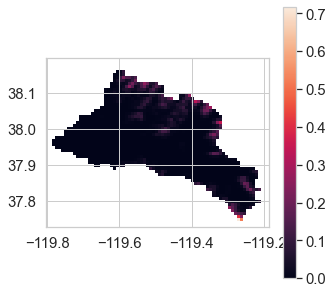

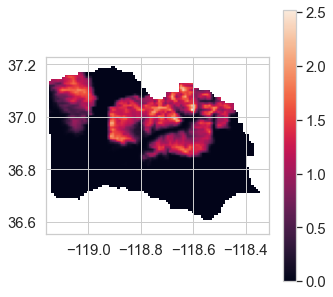

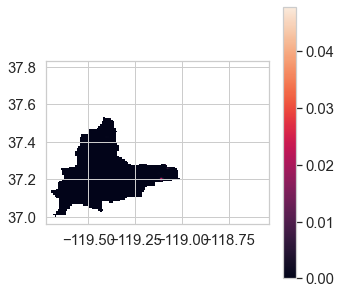

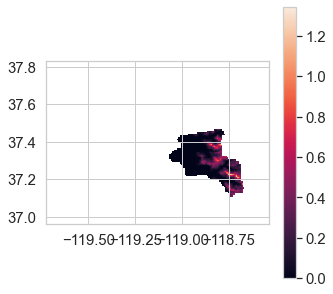

In [ ]:
ASO_files = ['Translated_Rescaled_800MReprojectedASO_50M_SWE_USCATB_20130608.tif', 'Translated_Rescaled_800MReprojectedASO_50M_SWE_USCAKC_20190428.tif', 'Translated_Rescaled_800MReprojectedASO_50M_SWE_USCAJW_20180602.tif', 'Translated_Rescaled_800MReprojectedASO_50M_SWE_USCASF_20180601.tif']
for ASO_file in ASO_files:
    with rio.open(ASO_file) as src:
        fig, ax = plt.subplots(figsize=(5,5))
        plt.imshow(src.read(1, masked=True))
        show(src.read(1, masked=True), transform = src.transform, ax=ax)
        plt.colorbar()

# Data processing of Topography files


In [ ]:
cd '/Users/lamaelhalabi/Documents/research Berekely /Lamas processing code/Maps/My Data/Topography'

/Users/lamaelhalabi/Documents/research Berekely /Lamas processing code/Maps/My Data/Topography


In [ ]:
PRISM_file_800M ='PRISM_PPT_20191121.tif'
Topography_file = 'Aspect_clipped_800.tif'

In [ ]:
gdal.Info(Topography_file).split('\n')

['Driver: GTiff/GeoTIFF',
 'Files: Aspect_clipped_800.tif',
 'Size is 196, 253',
 'Coordinate System is:',
 'GEOGCRS["NAD83",',
 '    DATUM["North American Datum 1983",',
 '        ELLIPSOID["GRS 1980",6378137,298.257222101004,',
 '            LENGTHUNIT["metre",1]]],',
 '    PRIMEM["Greenwich",0,',
 '        ANGLEUNIT["degree",0.0174532925199433]],',
 '    CS[ellipsoidal,2],',
 '        AXIS["geodetic latitude (Lat)",north,',
 '            ORDER[1],',
 '            ANGLEUNIT["degree",0.0174532925199433]],',
 '        AXIS["geodetic longitude (Lon)",east,',
 '            ORDER[2],',
 '            ANGLEUNIT["degree",0.0174532925199433]],',
 '    ID["EPSG",4269]]',
 'Data axis to CRS axis mapping: 2,1',
 'Origin = (-119.945833333536498,38.245833333799510)',
 'Pixel Size = (0.008333333333000,-0.008333333333000)',
 'Metadata:',
 '  AREA_OR_POINT=Area',
 '  PROCESSING_HISTORY=2021-06-03 03:19:28.291212 UTC | RichDEM (Python 0.3.4) (hash="Unknown", hashdate="Unknown") | LoadGDAL(filename=/Us

In [ ]:
gdal.Info(PRISM_file_800M).split('\n')

['Driver: GTiff/GeoTIFF',
 'Files: PRISM_PPT_20191121.tif',
 'Size is 196, 253',
 'Coordinate System is:',
 'GEOGCRS["NAD83",',
 '    DATUM["North American Datum 1983",',
 '        ELLIPSOID["GRS 1980",6378137,298.257222101004,',
 '            LENGTHUNIT["metre",1]]],',
 '    PRIMEM["Greenwich",0,',
 '        ANGLEUNIT["degree",0.0174532925199433]],',
 '    CS[ellipsoidal,2],',
 '        AXIS["geodetic latitude (Lat)",north,',
 '            ORDER[1],',
 '            ANGLEUNIT["degree",0.0174532925199433]],',
 '        AXIS["geodetic longitude (Lon)",east,',
 '            ORDER[2],',
 '            ANGLEUNIT["degree",0.0174532925199433]],',
 '    ID["EPSG",4269]]',
 'Data axis to CRS axis mapping: 2,1',
 'Origin = (-119.945833333536513,38.245833333799503)',
 'Pixel Size = (0.008333333333000,-0.008333333333000)',
 'Metadata:',
 '  AREA_OR_POINT=Area',
 'Image Structure Metadata:',
 '  INTERLEAVE=BAND',
 'Corner Coordinates:',
 'Upper Left  (-119.9458333,  38.2458333) (119d56\'45.00"W, 38d

Topography files are in the same coordinate system as PRISM files and are of the same resolution and pixel size --> no need for reprojection, aggregation, or rescaling. We only need to align.

In [ ]:
files = ['Aspect_clipped_800.tif', 'DEM_clipped_800.tif', 'Slope_clipped_800.tif']
template_file = PRISM_file_800M
for file in files:
    #we are aligning file according to the prism file
    Points_gdf = get_Points_gdf(template_file)
    translated_topography_file = 'Translated_' + file
    translate_rescaled_src(template_file, file, file, Points_gdf, translated_topography_file)

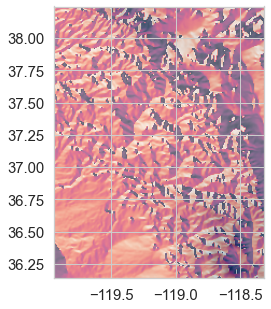

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))

with rio.open(PRISM_file_800M) as src:
    show(src.read(1, masked=True), ax=ax, transform=src.transform, cmap = 'Blues')

with rio.open('Translated_Aspect_clipped_800.tif') as src:
        show(src.read(1, masked=True), ax=ax, transform=src.transform, alpha=0.6)

# Generatre Datasets (CSV files)

In [ ]:
def get_ASO_Points_gdf(ASO_file):
    """This function reads in a raster, and obtains Long/Lat values of the center
    of each pixel. It returns a geodataframe."""
    raster = rio.open(ASO_file)
    arr = raster.read(1)
    indices = np.argwhere(~np.isnan(arr))

    coords = raster.xy(indices[:,0], indices[:,1])

    Points_gdf= gpd.GeoDataFrame({'Longitude':coords[0],'Latitude': coords[1]},
                                  geometry=[shapely.geometry.Point(x, y) for x, y in zip(coords[0], coords[1])])

    raster.close()
    return Points_gdf

def get_PRISM_PPT_df(number_of_days, PRISM_folder_path, ASO_date, Points_gdf):
    """This function samples PRISM precipitation values for a number of days leading upto (and including)
    the ASO snapshot. The PRISM values are sampled for the same pixels for which we have ASO
    data.
    """
    PRISM_df = pd.DataFrame() #initialize empty data frame (data frame is a dict)

    for i in np.arange(number_of_days):
        PRISM_date = (ASO_date + datetime.timedelta(days=-int(i))).strftime('%Y%m%d') # we start from the ASO_dat and SUBTARACT a day (-int(i))
        year = PRISM_date[:4] # first 4 elements in date
        PRISM_file = f'{PRISM_folder_path}/{year}/PRISM_PPT_{PRISM_date}.tif' #this takes us to the prism_file for the given date at each iteration i

        with rio.open(PRISM_file) as src:
            PRISM_values = pd.Series([val[0] for val in src.sample(zip(Points_gdf['Longitude'], Points_gdf['Latitude']))]) #for every pixel what is the value of precipitation
            PRISM_df.insert(int(i), str(i), pd.Series(PRISM_values)) #inserts it in dataframe

    return PRISM_df


def get_PRISM_TAVG_df(number_of_days, PRISM_folder_path, ASO_date, Points_gdf):
    """This function samples PRISM mean temperature values for a number of days leading upto (and including)
    the ASO snapshot. The PRISM values are sampled for the same pixels for which we have ASO
    data."""
    PRISM_df = pd.DataFrame()

    for i in np.arange(number_of_days):
        PRISM_date = (ASO_date + datetime.timedelta(days=-int(i))).strftime('%Y%m%d')
        year = PRISM_date[:4]
        PRISM_file = f'{PRISM_folder_path}/{year}/PRISM_TAVG_{PRISM_date}.tif'

        with rio.open(PRISM_file) as src:
            PRISM_values = pd.Series([val[0] for val in src.sample(zip(Points_gdf['Longitude'], Points_gdf['Latitude']))])
            PRISM_df.insert(int(i), str(i), pd.Series(PRISM_values))

    return PRISM_df

In [ ]:
def ASO_to_CSV(ASO_files, truncate_file):
'''  This function taken in raster .tif files and creates csv files.  the CSV files contain 8 columns: longitude, latitue,
slope, aspect, DEM, Sum PDD, Accumulated snow, accumulated precipitation, average temperature, and SWE. It also takes in an optional truncate file
which defines the spatial extent (longitude and latitude) of the CSV file.  '''


    for ASO_file in ASO_files:

        #1. PRISM_FILE PATHS
        PRISM_PPT_folder_path = '/Users/lamaelhalabi/Documents/research Berekely /Lamas processing code/Maps/My Data/800M/Prism_data/PPT_ASO_California_PRISM800'
        PRISM_TAVG_folder_path = '/Users/lamaelhalabi/Documents/research Berekely /Lamas processing code/Maps/My Data/800M/Prism_data/TAVG_ASO_California_PRISM800'

        #2.  ASO DATE : From ASO_file string
        ASO_date_str = ASO_file.split('_')[6]
        ASO_date_str = ASO_date_str[: 8]
        ASO_str_indicator = ASO_file.split('_')[5] + ASO_file.split('_')[6]
        ASO_str_indicator = ASO_str_indicator[4: 14]

        #3. GET Lat and Long and PRISM_PPT and PRISM_TAVG dataframes
        ASO_date = datetime.datetime.strptime(ASO_date_str,"%Y%m%d")
        start_date = datetime.datetime(ASO_date.year-1, 11, 1) # Start date = November 1
        number_of_days = (ASO_date - start_date).days + 1
        if truncate_file == 'none':
            Points_gdf = get_ASO_Points_gdf(ASO_file)
        else:
            Points_gdf = get_ASO_Points_gdf(truncate_file)

        PRISM_PPT_df = get_PRISM_PPT_df(number_of_days, PRISM_PPT_folder_path, ASO_date, Points_gdf)
        PRISM_TAVG_df = get_PRISM_TAVG_df(number_of_days, PRISM_TAVG_folder_path, ASO_date, Points_gdf)

        #4. Get Accumulated PRECIPITATION AND AVERGAE TEMPERATURE
        Accumulated_Prec = np.sum(PRISM_PPT_df,  axis=1)
        Average_Temp = np.mean(PRISM_TAVG_df,  axis=1)

        #5. GET PRISM_SNOW Dataframe
        PRISM_snow_df = PRISM_PPT_df.copy(deep=True)
        PRISM_snow_df.where(PRISM_TAVG_df <= 0.0, other=0.0, inplace=True)

        #6. Get Accumulated snow
        Accumulated_snow = np.sum(PRISM_snow_df.iloc[:,:number_of_days], axis=1)

        #7. Get PRISM_PDD_df
        Prism_PDD_df = PRISM_TAVG_df.iloc[:,:number_of_days].where(PRISM_TAVG_df.iloc[:,:number_of_days] > 0.0, other=0.0)

        #8. Get SUM PDD
        SUM_PDD = np.sum(Prism_PDD_df.iloc[:,:number_of_days], axis=1)


        #9. ASO and TOPOGRAPHY FILE PATHs: ASO, SLOPE, ASPECT, and DEM
        Topography_file_path_Slope = '/Users/lamaelhalabi/Documents/research Berekely /Lamas processing code/Maps/My Data/800M/Topography/Translated_Slope_clipped_800.tif'
        Topography_file_path_Aspect = '/Users/lamaelhalabi/Documents/research Berekely /Lamas processing code/Maps/My Data/800M/Topography/Translated_Aspect_clipped_800.tif'
        Topography_file_path_DEM = '/Users/lamaelhalabi/Documents/research Berekely /Lamas processing code/Maps/My Data/800M/Topography/Translated_DEM_clipped_800.tif'
        ASO_file_path ='/Users/lamaelhalabi/Documents/research Berekely /Lamas processing code/Maps/My Data/800M/' + ASO_file

        #10. Create Topography values and ASO value
        with rio.open(Topography_file_path_Slope) as src:
            Topography_values_Slope = pd.Series([val[0] for val in src.sample(zip(Points_gdf['Longitude'], Points_gdf['Latitude']))])

        with rio.open(Topography_file_path_Aspect) as src:
            Topography_values_Aspect = pd.Series([val[0] for val in src.sample(zip(Points_gdf['Longitude'], Points_gdf['Latitude']))])

        with rio.open(Topography_file_path_DEM) as src:
            Topography_values_DEM = pd.Series([val[0] for val in src.sample(zip(Points_gdf['Longitude'], Points_gdf['Latitude']))])

        with rio.open(ASO_file_path) as src:
            ASO_values = pd.Series([val[0] for val in src.sample(zip(Points_gdf['Longitude'], Points_gdf['Latitude']))])

        #11. create CSV file
        Data_set = pd.DataFrame({'Longitude': Points_gdf['Longitude'], 'Latitude': Points_gdf['Latitude'], 'Slope': Topography_values_Slope, 'Aspect': Topography_values_Aspect, 'DEM': Topography_values_DEM, 'Sum PDD': SUM_PDD, 'Accumulated Snow': Accumulated_snow, 'Accumulate Precipitation': Accumulated_Prec, 'Average Temperature': Average_Temp, 'SWE': ASO_values})
        Data_set.to_csv(ASO_str_indicator + '_Data_set_SWE.csv', index=True)
        Data_set = pd.read_csv(ASO_str_indicator + '_Data_set_SWE.csv', index_col=0)



# FINDING START DATE FOR SNOW ACCUMULATION AND PDD (NOVEMBER 1 FOR BOTH)

In [ ]:
'''The start date of the melt/snow season was determined for Colorado and California by a backward
time accumulation of PDD/snow '''

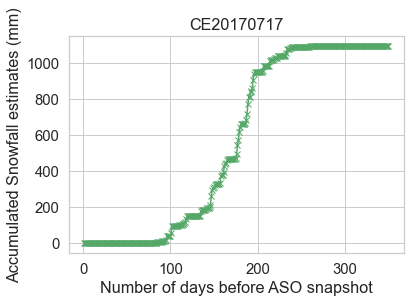

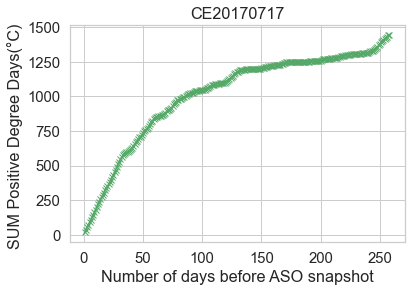

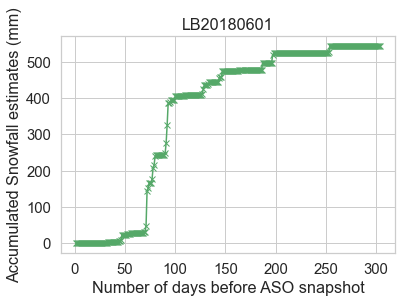

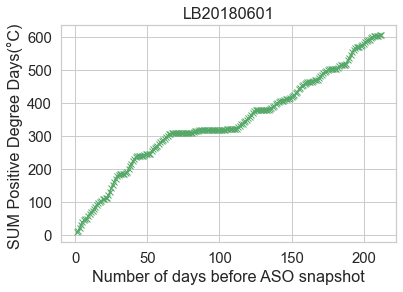

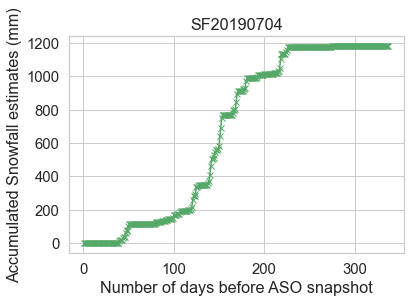

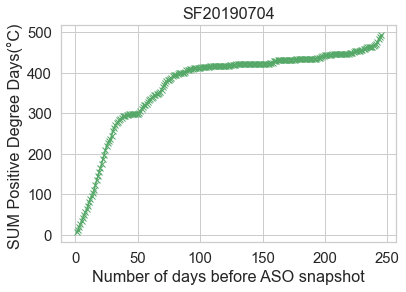

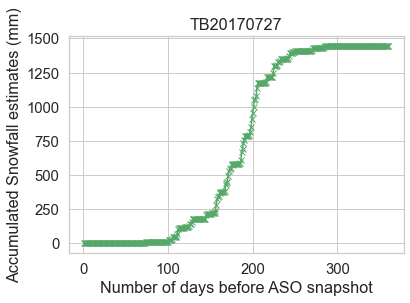

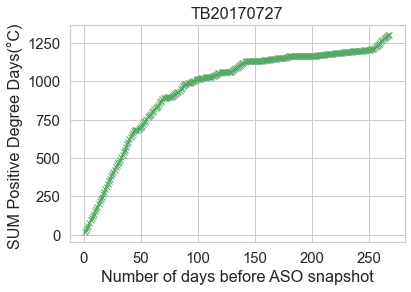

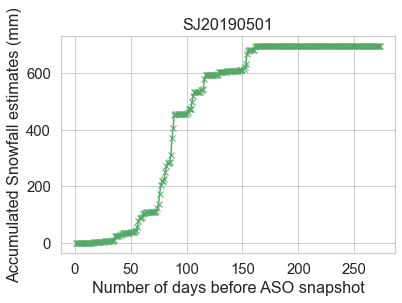

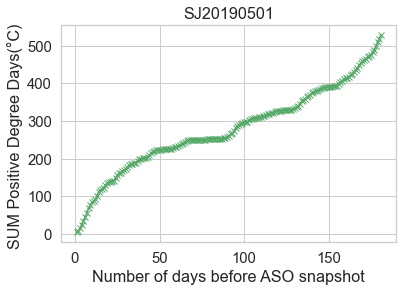

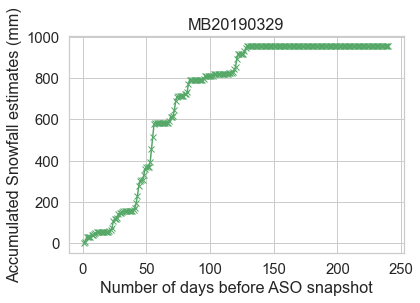

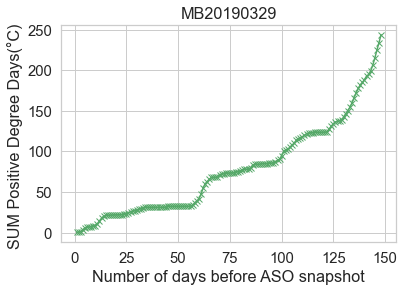

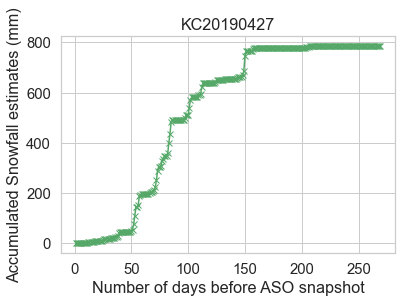

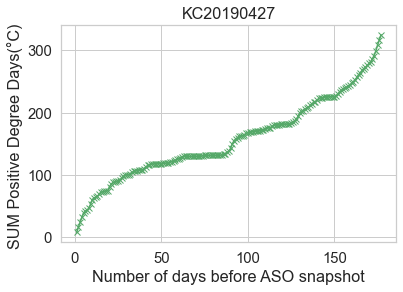

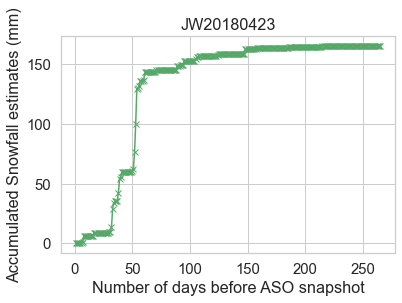

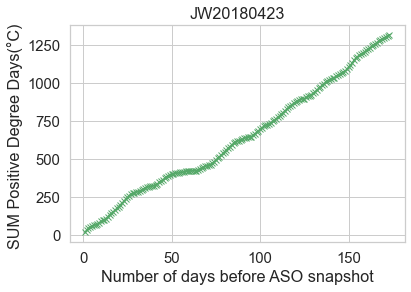

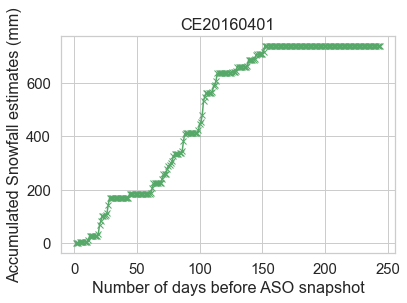

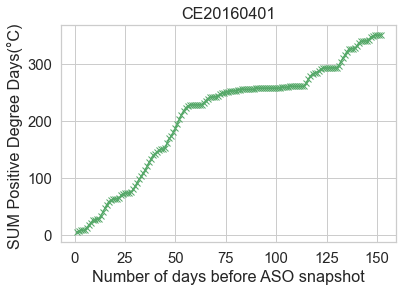

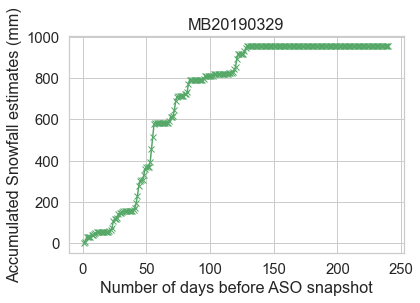

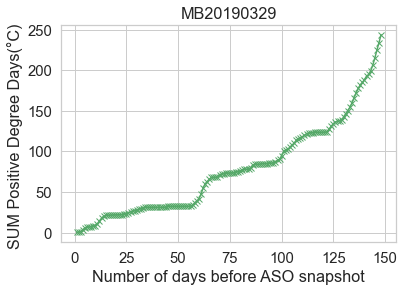

In [ ]:
ASO = ['Translated_Rescaled_800MReprojectedASO_50M_SWE_USCACE_20170717.tif', 'Translated_Rescaled_800MReprojectedASO_50M_SWE_USCALB_20180601.tif',
       'Translated_Rescaled_800MReprojectedASO_50M_SWE_USCASF_20190704.tif', 'Translated_Rescaled_800MReprojectedASO_50M_SWE_USCATB_20170727.tif',
       'Translated_Rescaled_800MReprojectedASO_50M_SWE_USCASJ_20190501.tif', 'Translated_Rescaled_800MReprojectedASO_50M_SWE_USCAMB_20190329.tif',
       'Translated_Rescaled_800MReprojectedASO_50M_SWE_USCAKC_20190427.tif', 'Translated_Rescaled_800MReprojectedASO_50M_SWE_USCAJW_20180423.tif',
       'Translated_Rescaled_800MReprojectedASO_50M_SWE_USCACE_20160401.tif']

for ASO_file in ASO:
    #1. PRISM_FILE PATHS
    PRISM_PPT_folder_path = '/Users/lamaelhalabi/Documents/research Berekely /Lamas processing code/Maps/My Data/800M/Prism_data/PPT_ASO_California_PRISM800'
    PRISM_TAVG_folder_path = '/Users/lamaelhalabi/Documents/research Berekely /Lamas processing code/Maps/My Data/800M/Prism_data/TAVG_ASO_California_PRISM800'

    #2.  ASO DATE : From ASO_file string and ASO indicator
    ASO_date_str = ASO_file.split('_')[6]
    ASO_date_str = ASO_date_str[: 8]
    ASO_str_indicator = ASO_file.split('_')[5] + ASO_file.split('_')[6]
    ASO_str_indicator = ASO_str_indicator[4: 14]
    ASO_date = datetime.datetime.strptime(ASO_date_str,"%Y%m%d")  #what is this? changing the type of ASO_date from 'str' to 'datetime.datetime'

    #3. GET Lat and Long for ASO File
    Points_gdf = get_ASO_Points_gdf(ASO_file)

    #4.0 Accumulated snow
    start_date_snow = datetime.datetime(ASO_date.year-1, 8, 1) # Start date = August 1 of the previous year
    number_of_days_snow = (ASO_date - start_date_snow).days + 1

    #4.1 Prism get PTT and TAVG
    PRISM_PPT_df = get_PRISM_PPT_df(number_of_days_snow, PRISM_PPT_folder_path, ASO_date, Points_gdf)
    PRISM_TAVG_df = get_PRISM_TAVG_df(number_of_days_snow, PRISM_TAVG_folder_path, ASO_date, Points_gdf)

    #4.2 GET PRISM_SNOW Dataframe
    PRISM_snow_df = PRISM_PPT_df.copy(deep=True)
    PRISM_snow_df.where(PRISM_TAVG_df <= 0.0, other=0.0, inplace=True)

    #4.3 Get Mean Accumulated snow (why mean , because we are averaging over all the pixels in the snapshot)
    mean_accum_snow = [np.mean(np.sum(PRISM_snow_df.iloc[:,:n_days], axis=1)) for n_days in range(1, number_of_days_snow)]

    #4.4 Plot Accumulated Snow
    plt.plot(range(1, number_of_days_snow), mean_accum_snow, '-xC2')
    plt.xlabel('Number of days before ASO snapshot')
    plt.ylabel('Accumulated Snowfall estimates (mm)')
    plt.title(ASO_str_indicator)
    plt.savefig(ASO_str_indicator + 'Snow.png', bbox_inches = 'tight')
    plt.show()

    #5.0 Sum PDD
    start_date_PDD = datetime.datetime(ASO_date.year-1, 11, 1) # Start date = November 1 of the previous year
    number_of_days_PDD= (ASO_date - start_date_PDD).days + 1

    #5.1 Prism get PTT and TAVG
    PRISM_PPT_df = get_PRISM_PPT_df(number_of_days_PDD, PRISM_PPT_folder_path, ASO_date, Points_gdf)
    PRISM_TAVG_df = get_PRISM_TAVG_df(number_of_days_PDD, PRISM_TAVG_folder_path, ASO_date, Points_gdf)

    #5.2 Get PRISM_PDD Dataframe
    Prism_PDD_df = PRISM_TAVG_df.iloc[:,:number_of_days_PDD].where(PRISM_TAVG_df.iloc[:,:number_of_days_PDD] > 0.0, other=0.0)

    #5.3 Get SUM PDD
    SUM_PDD = [np.mean(np.sum(Prism_PDD_df.iloc[:,:n_days], axis=1)) for n_days in range(1, number_of_days_PDD)]

    #5.4 Plot SUM PDD
    plt.plot(range(1, number_of_days_PDD), SUM_PDD, '-xC2')
    plt.xlabel('Number of days before ASO snapshot')
    plt.ylabel('SUM Positive Degree Days(°C) ')
    plt.title(ASO_str_indicator)
    plt.savefig( ASO_str_indicator + 'PDD.png', bbox_inches = 'tight')
    plt.show()

# Generating CSV file for each basin

## Seperate ASO files in lists according to basin.

In [ ]:
data_path = "/Users/lamaelhalabi/Documents/research Berekely /Lamas processing code/Maps/My Data/800M"
data_dir = os.listdir(data_path)

#create an empty list of ASO files
ASO_files_CE = []
ASO_files_JW = []
ASO_files_KC = []
ASO_files_KN = []
ASO_files_KW = []
ASO_files_LB = []
ASO_files_LV = []
ASO_files_MB = []
ASO_files_RC = []
ASO_files_SF = []
ASO_files_SJ = []
ASO_files_TB = []
ASO_files_TE = []

# for each folder in the directory
for s in data_dir:  #remove the .xml files
    if '.xml' not in s and 'Translated_Rescaled' in s:
        if 'USCACE' in s:
            ASO_files_CE.append(s)
        if 'USCAJW' in s:
            ASO_files_JW.append(s)
        if 'USCAKC' in s:
            ASO_files_KC.append(s)
        if 'USCAKW' in s:
            ASO_files_KW.append(s)
        if 'USCALB' in s:
            ASO_files_LB.append(s)
        if 'USCALV' in s:
            ASO_files_LV.append(s)
        if 'USCAMB' in s:
            ASO_files_MB.append(s)
        if 'USCARC' in s:
            ASO_files_RC.append(s)
        if 'USCASF' in s:
            ASO_files_SF.append(s)
        if 'USCASJ' in s:
            ASO_files_SJ.append(s)
        if 'USCATB' in s:
            ASO_files_TB.append(s)
        if 'USCATE' in s:
            ASO_files_TE.append(s)
        if 'USCAKN' in s:
            ASO_files_KN.append(s)


ASO_files_CE = sorted(ASO_files_CE)
ASO_files_JW = sorted(ASO_files_JW)
ASO_files_KC = sorted(ASO_files_KC)
ASO_files_KN = sorted(ASO_files_KN)
ASO_files_KW = sorted(ASO_files_KW)
ASO_files_LB = sorted(ASO_files_LB)
ASO_files_LV = sorted(ASO_files_LV)
ASO_files_MB = sorted(ASO_files_MB)
ASO_files_RC = sorted(ASO_files_RC)
ASO_files_SF = sorted(ASO_files_SF)
ASO_files_SJ = sorted(ASO_files_SJ)
ASO_files_TB = sorted(ASO_files_TB)
ASO_files_TE = sorted(ASO_files_TE)



## Generating CE CSV files

['Translated_Rescaled_800MReprojectedASO_50M_SWE_USCACE_20160401.tif', 'Translated_Rescaled_800MReprojectedASO_50M_SWE_USCACE_20160407.tif', 'Translated_Rescaled_800MReprojectedASO_50M_SWE_USCACE_20160416.tif', 'Translated_Rescaled_800MReprojectedASO_50M_SWE_USCACE_20160426.tif', 'Translated_Rescaled_800MReprojectedASO_50M_SWE_USCACE_20160509.tif', 'Translated_Rescaled_800MReprojectedASO_50M_SWE_USCACE_20170129.tif', 'Translated_Rescaled_800MReprojectedASO_50M_SWE_USCACE_20170717.tif', 'Translated_Rescaled_800MReprojectedASO_50M_SWE_USCACE_20170727.tif', 'Translated_Rescaled_800MReprojectedASO_50M_SWE_USCACE_20170816.tif', 'Translated_Rescaled_800MReprojectedASO_50M_SWE_USCACE_20180423.tif', 'Translated_Rescaled_800MReprojectedASO_50M_SWE_USCACE_20180528.tif']


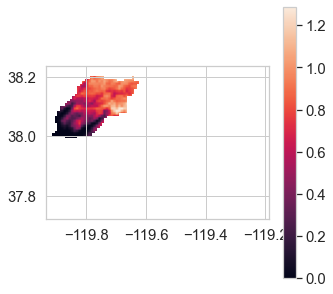

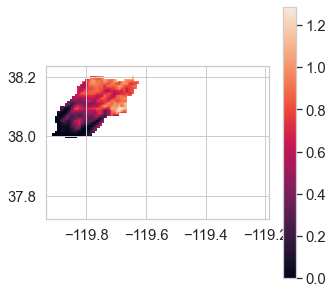

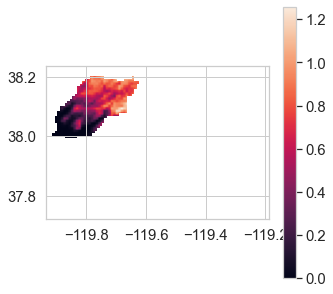

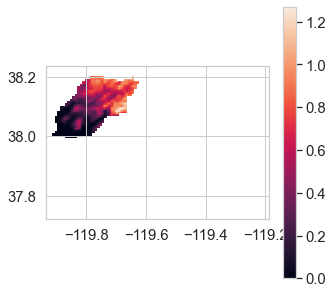

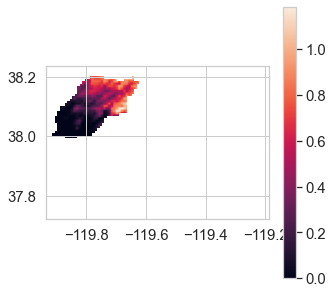

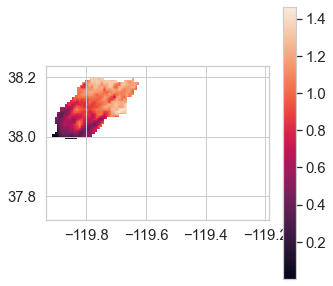

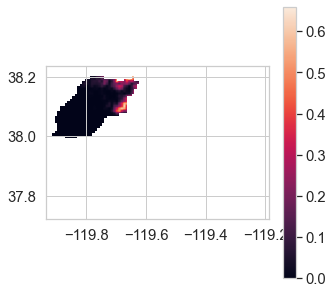

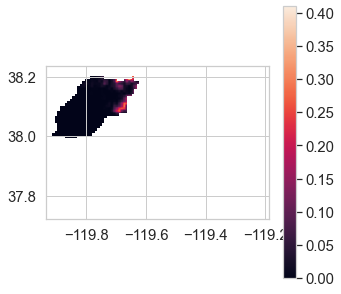

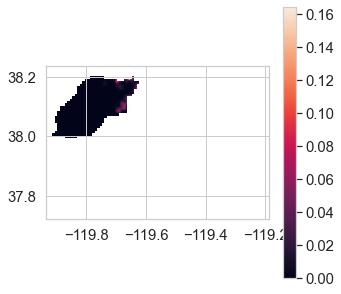

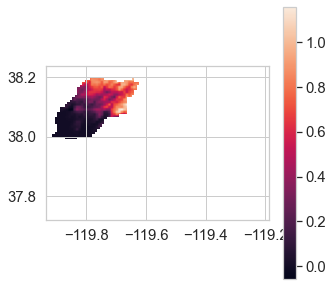

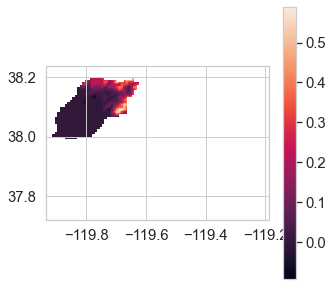

In [ ]:
for ASO_file in ASO_files_CE:
    with rio.open(ASO_file) as src:
        fig, ax = plt.subplots(figsize=(5,5))
        plt.imshow(src.read(1, masked=True),)
        show(src.read(1, masked=True), transform = src.transform, ax=ax)
        plt.colorbar()
print(ASO_files_CE)

In [ ]:
for ASO_file in ASO_files_CE:
    #1. PRISM_FILE PATHS
    PRISM_PPT_folder_path = '/Users/lamaelhalabi/Documents/research Berekely /Lamas processing code/Maps/My Data/800M/Prism_data/PPT_ASO_California_PRISM800'
    PRISM_TAVG_folder_path = '/Users/lamaelhalabi/Documents/research Berekely /Lamas processing code/Maps/My Data/800M/Prism_data/TAVG_ASO_California_PRISM800'

    #2.  ASO DATE : From ASO_file string
    ASO_date_str = ASO_file.split('_')[6]
    ASO_date_str = ASO_date_str[: 8]
    ASO_str_indicator = ASO_file.split('_')[5] + ASO_file.split('_')[6]
    ASO_str_indicator = ASO_str_indicator[4: 14]

    #3. GET Lat and Long and PRISM_PPT and PRISM_TAVG dataframes
    ASO_date = datetime.datetime.strptime(ASO_date_str,"%Y%m%d")
    start_date = datetime.datetime(ASO_date.year-1, 11, 1) # Start date = November 1
    number_of_days = (ASO_date - start_date).days + 1
    Points_gdf = get_ASO_Points_gdf(ASO_files_CE[1])

    PRISM_PPT_df = get_PRISM_PPT_df(number_of_days, PRISM_PPT_folder_path, ASO_date, Points_gdf)
    PRISM_TAVG_df = get_PRISM_TAVG_df(number_of_days, PRISM_TAVG_folder_path, ASO_date, Points_gdf)

    #4. Get Accumulated PRECIPITATION AND AVERGAE TEMPERATURE
    Accumulated_Prec = np.sum(PRISM_PPT_df,  axis=1)
    Average_Temp = np.mean(PRISM_TAVG_df,  axis=1)

    #5. GET PRISM_SNOW Dataframe
    PRISM_snow_df = PRISM_PPT_df.copy(deep=True)
    PRISM_snow_df.where(PRISM_TAVG_df <= 0.0, other=0.0, inplace=True)

    #6. Get Accumulated snow
    Accumulated_snow = np.sum(PRISM_snow_df.iloc[:,:number_of_days], axis=1)
    print(Accumulated_snow)

    #7. Get PRISM_PDD_df
    Prism_PDD_df = PRISM_TAVG_df.iloc[:,:number_of_days].where(PRISM_TAVG_df.iloc[:,:number_of_days] > 0.0, other=0.0)

    #8. Get SUM PDD
    SUM_PDD = np.sum(Prism_PDD_df.iloc[:,:number_of_days], axis=1)
    print(SUM_PDD)

    #9. ASO and TOPOGRAPHY FILE PATHs: ASO, SLOPE, ASPECT, and DEM
    Topography_file_path_Slope = '/Users/lamaelhalabi/Documents/research Berekely /Lamas processing code/Maps/My Data/800M/Topography/Translated_Slope_clipped_800.tif'
    Topography_file_path_Aspect = '/Users/lamaelhalabi/Documents/research Berekely /Lamas processing code/Maps/My Data/800M/Topography/Translated_Aspect_clipped_800.tif'
    Topography_file_path_DEM = '/Users/lamaelhalabi/Documents/research Berekely /Lamas processing code/Maps/My Data/800M/Topography/Translated_DEM_clipped_800.tif'
    ASO_file_path ='/Users/lamaelhalabi/Documents/research Berekely /Lamas processing code/Maps/My Data/800M/' + ASO_file

    #10. Create Topography values and ASO value
    with rio.open(Topography_file_path_Slope) as src:
        Topography_values_Slope = pd.Series([val[0] for val in src.sample(zip(Points_gdf['Longitude'], Points_gdf['Latitude']))])

    with rio.open(Topography_file_path_Aspect) as src:
        Topography_values_Aspect = pd.Series([val[0] for val in src.sample(zip(Points_gdf['Longitude'], Points_gdf['Latitude']))])

    with rio.open(Topography_file_path_DEM) as src:
        Topography_values_DEM = pd.Series([val[0] for val in src.sample(zip(Points_gdf['Longitude'], Points_gdf['Latitude']))])

    with rio.open(ASO_file_path) as src:
        ASO_values = pd.Series([val[0] for val in src.sample(zip(Points_gdf['Longitude'], Points_gdf['Latitude']))])

    #11. create CSV file
    Data_set = pd.DataFrame({'Longitude': Points_gdf['Longitude'], 'Latitude': Points_gdf['Latitude'], 'Slope': Topography_values_Slope, 'Aspect': Topography_values_Aspect, 'DEM': Topography_values_DEM, 'Sum PDD': SUM_PDD, 'Accumulated Snow': Accumulated_snow, 'Accumulate Precipitation': Accumulated_Prec, 'Average Temperature': Average_Temp, 'SWE': ASO_values})
    Data_set.to_csv(ASO_str_indicator + 'Data_set_SWE.csv', index=True)
    Data_set = pd.read_csv(ASO_str_indicator + 'Data_set_SWE.csv', index_col=0)


0      1239.759217
1      1027.385047
2      1220.479732
3      1006.900213
4      1006.852864
          ...     
579     161.817844
580     108.466339
581     149.277505
582     149.879510
583     248.919843
Length: 584, dtype: float64
0      127.855505
1      213.895010
2      147.280008
3      215.086012
4      223.100008
          ...    
579    808.109542
580    879.434044
581    873.614532
582    814.364538
583    631.251530
Length: 584, dtype: float64
0      1239.759217
1      1027.385047
2      1220.479732
3      1006.900213
4      1006.852864
          ...     
579     161.817844
580     108.466339
581     149.277505
582     149.879510
583     248.919843
Length: 584, dtype: float64
0      151.350507
1      250.890013
2      173.020009
3      252.191014
4      260.435010
          ...    
579    893.524546
580    970.329047
581    964.279536
582    900.439541
583    702.861032
Length: 584, dtype: float64
0      1257.208384
1      1028.876047
2      1238.326733
3      1008.43921

## Generating CSV files for all other basins

### Visualizing ASO files to decide on truncation files and inspect for numerical artifacts

4
8
2
3


<ipython-input-7-d598b6da6990>:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(5,5))


15
1
5
1
8
10
20
6


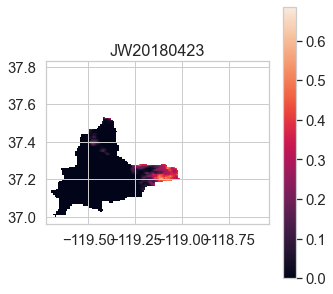

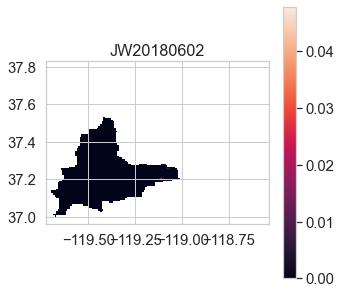

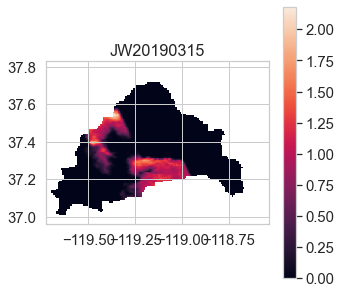

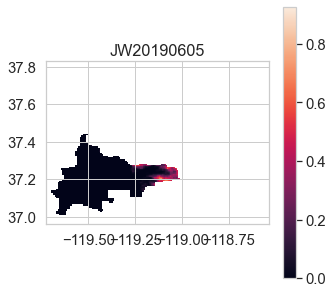

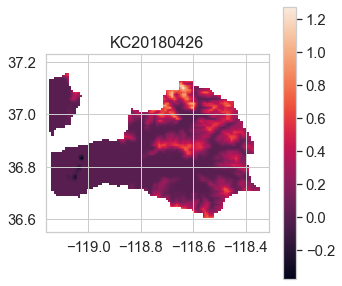

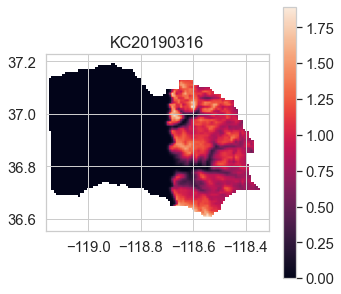

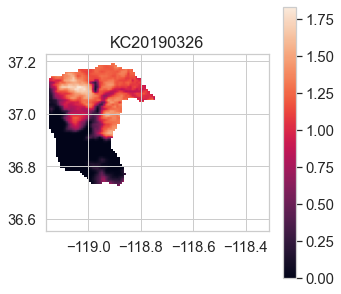

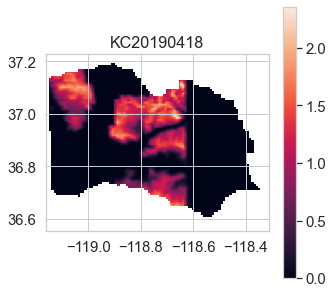

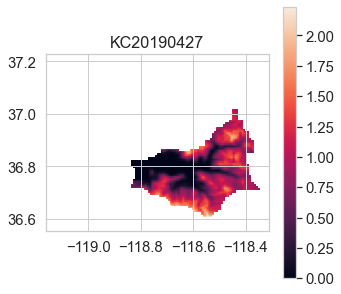

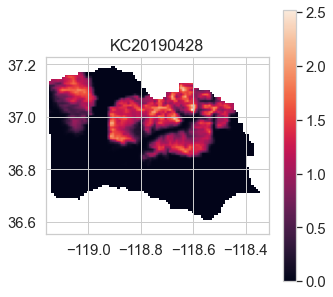

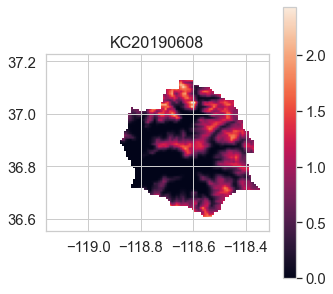

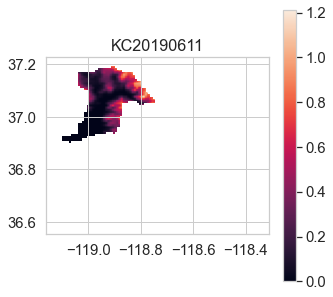

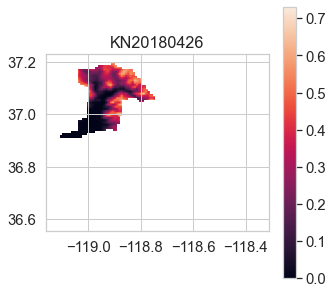

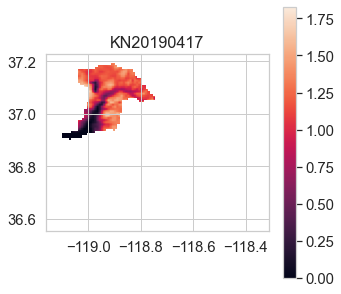

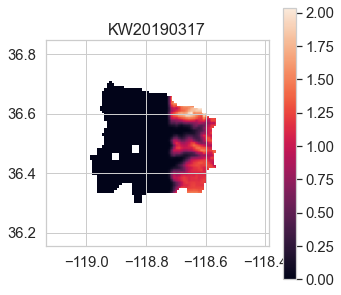

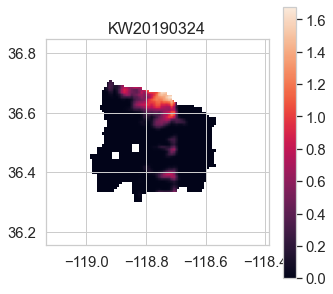

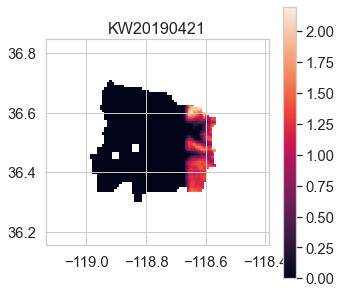

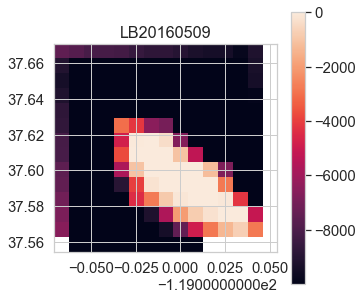

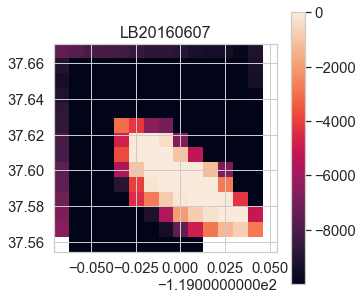

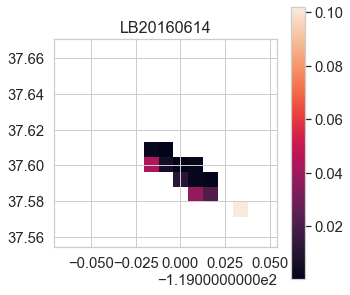

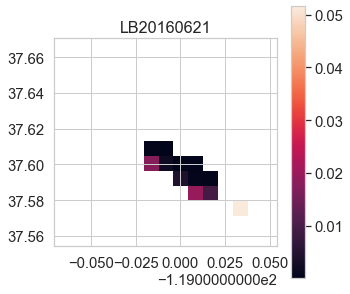

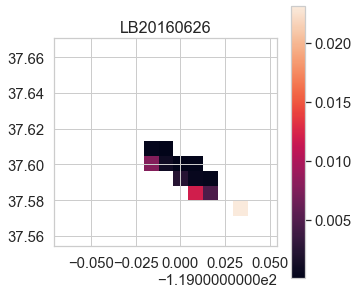

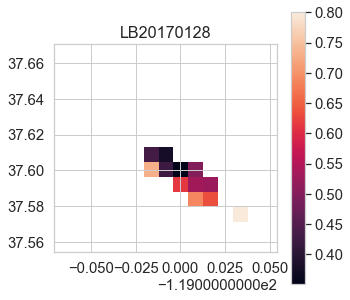

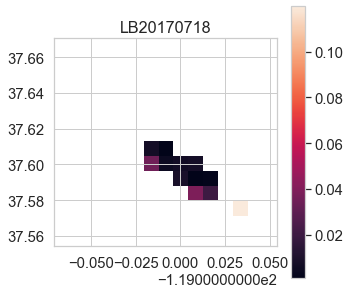

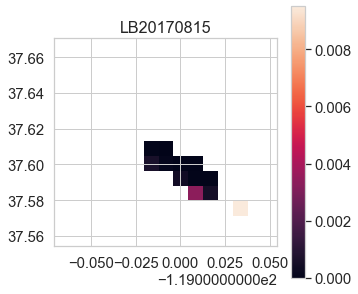

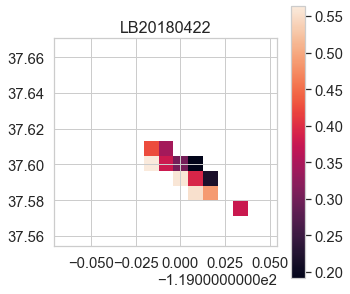

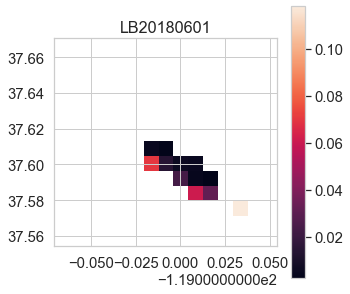

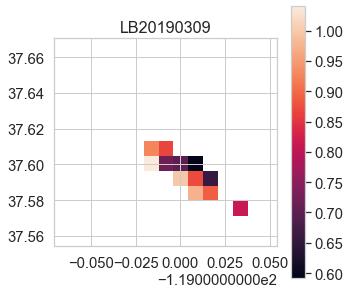

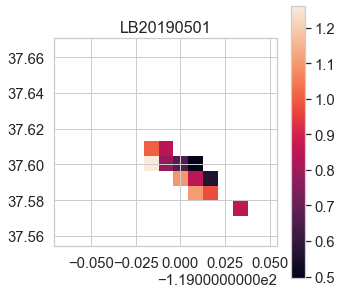

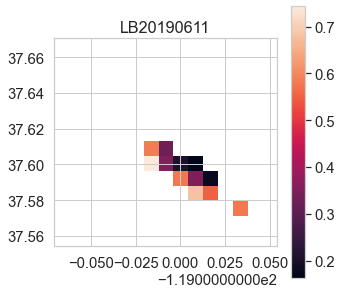

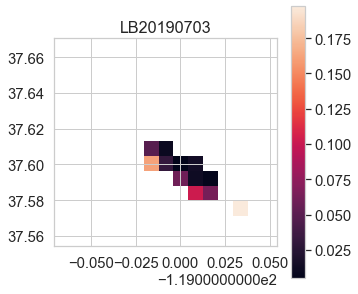

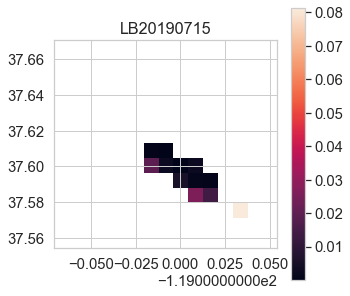

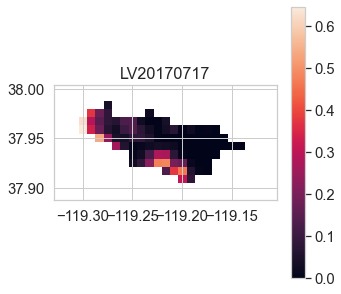

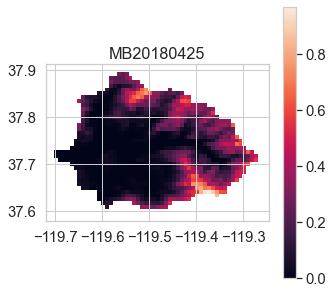

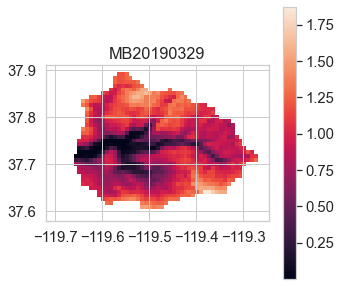

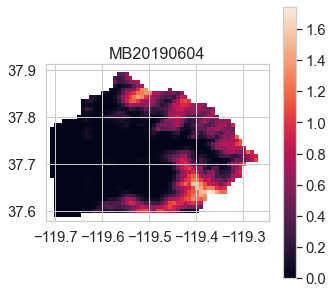

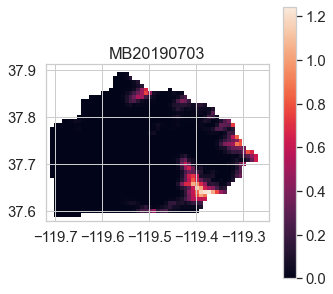

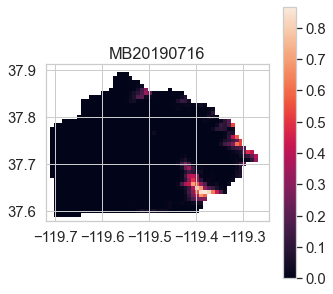

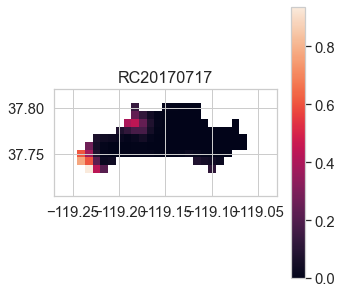

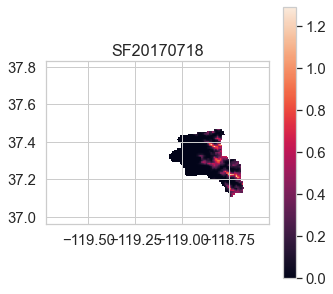

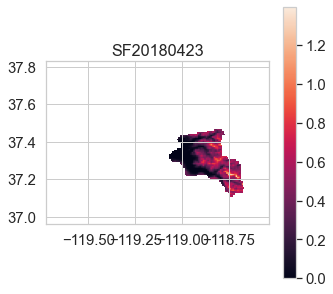

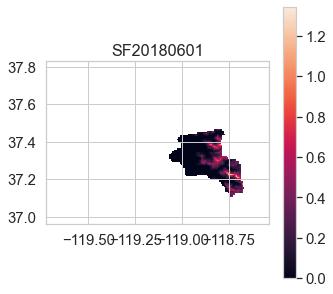

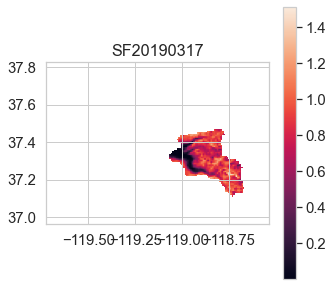

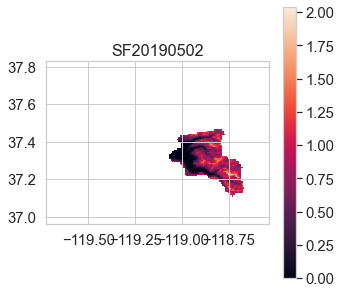

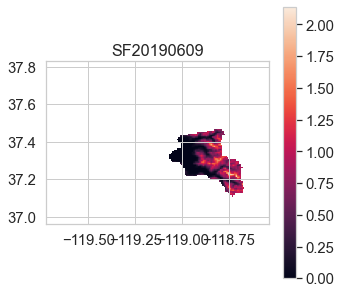

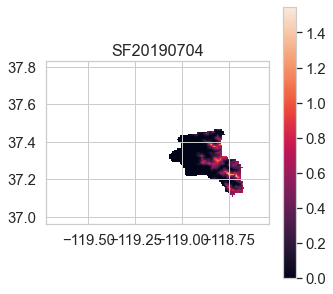

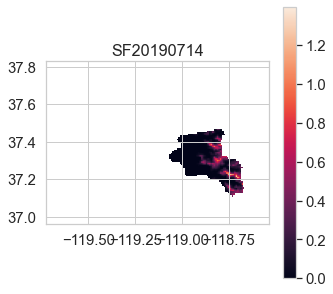

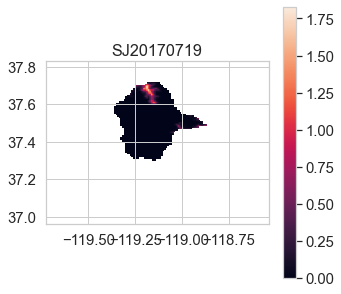

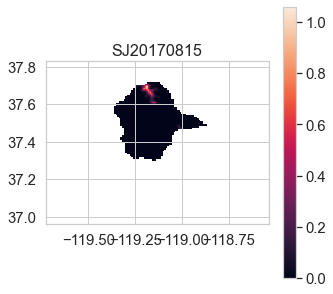

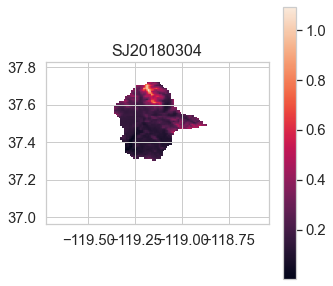

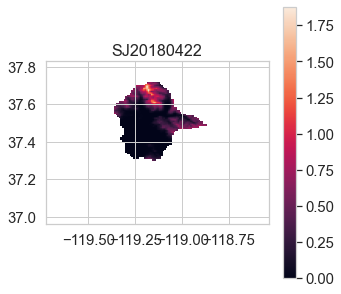

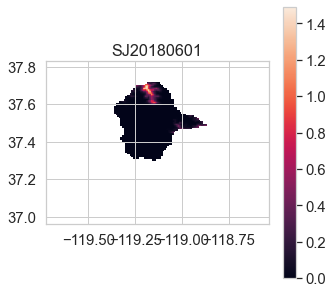

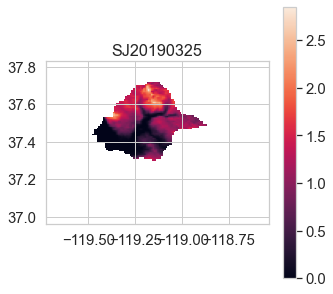

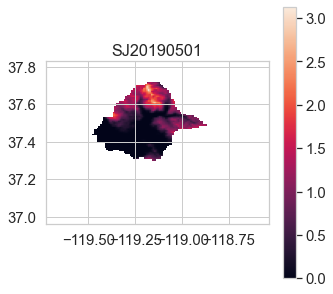

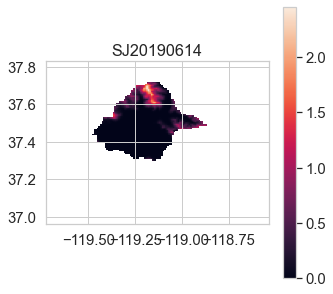

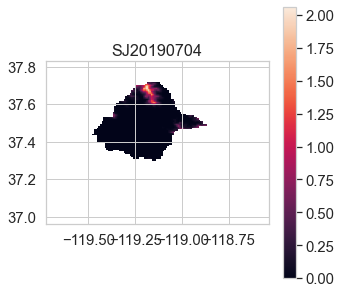

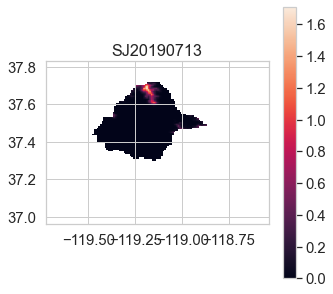

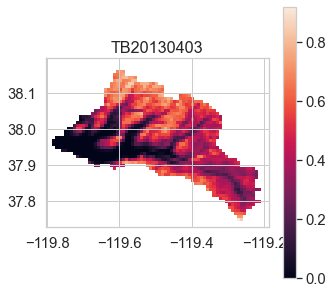

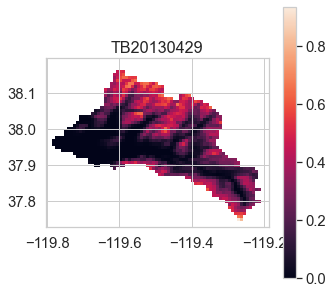

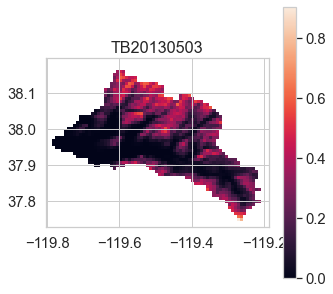

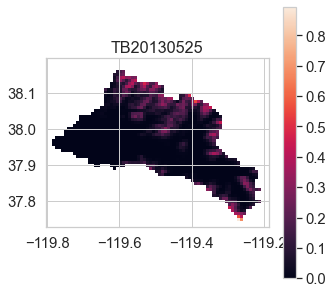

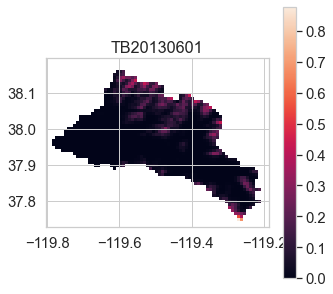

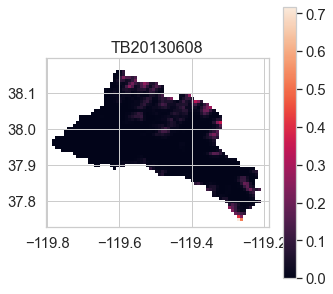

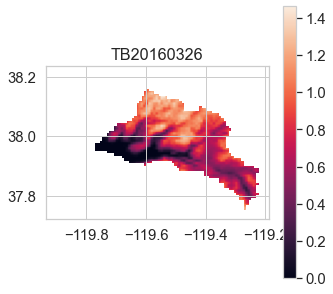

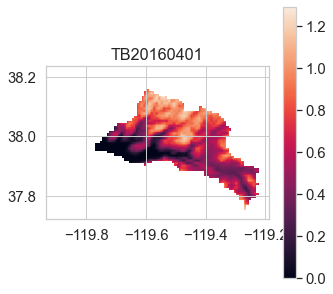

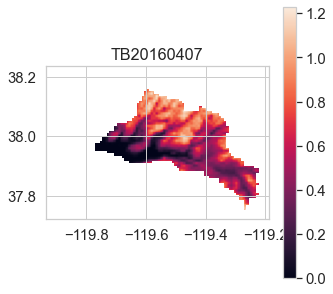

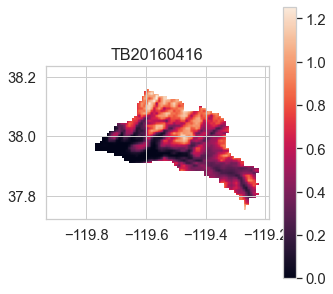

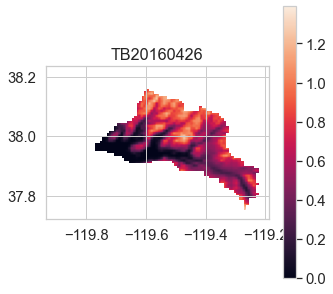

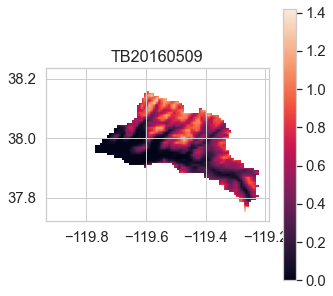

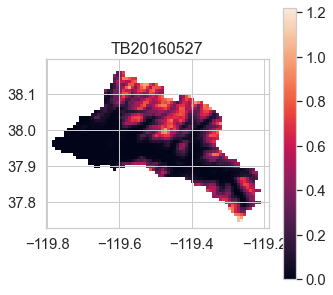

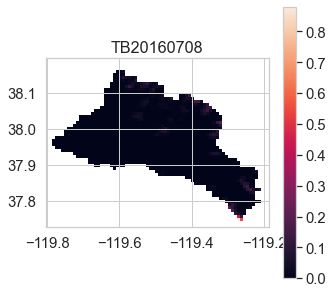

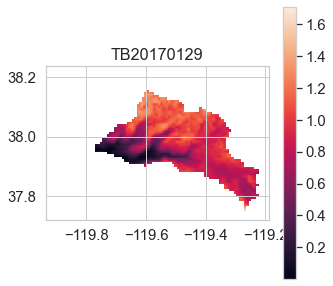

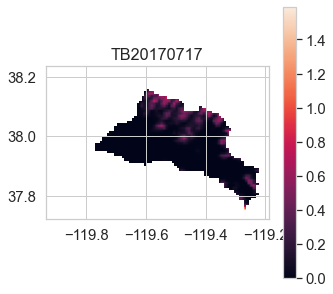

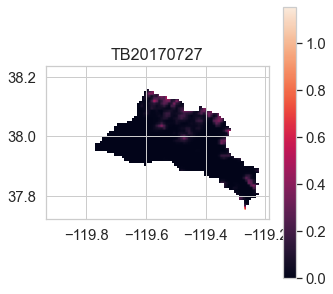

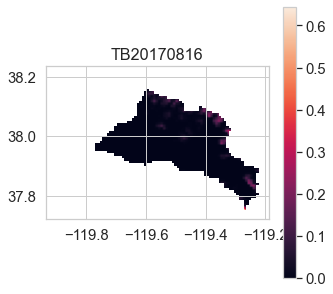

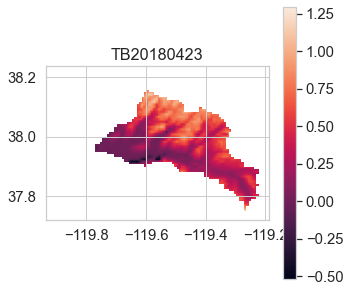

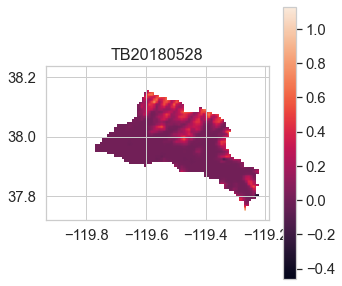

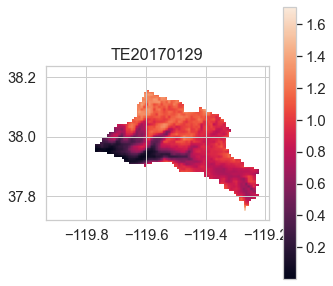

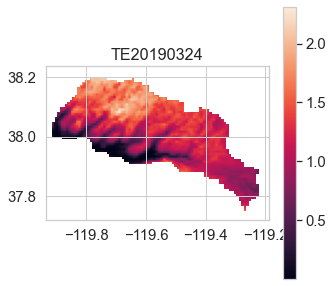

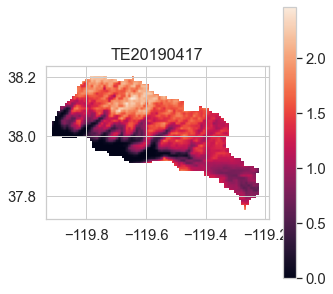

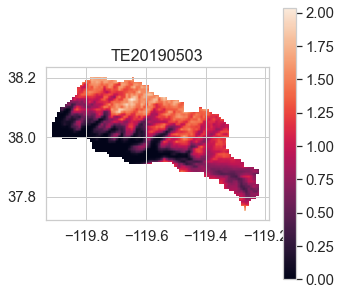

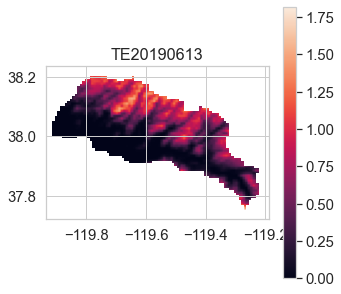

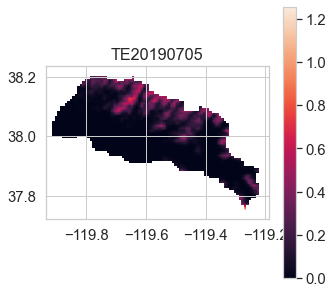

In [ ]:
for ASO_file in ASO_files_JW:
    with rio.open(ASO_file) as src:
        fig, ax = plt.subplots(figsize=(5,5))
        plt.imshow(src.read(1, masked=True),)
        show(src.read(1, masked=True), transform = src.transform, ax=ax)
        ASO_str_indicator = ASO_file.split('_')[5] + ASO_file.split('_')[6]
        ASO_str_indicator = ASO_str_indicator[4: 14]
        plt.title(ASO_str_indicator)
        plt.colorbar()
print(len(ASO_files_JW))

for ASO_file in ASO_files_KC:
    with rio.open(ASO_file) as src:
        fig, ax = plt.subplots(figsize=(5,5))
        plt.imshow(src.read(1, masked=True),)
        show(src.read(1, masked=True), transform = src.transform, ax=ax)
        ASO_str_indicator = ASO_file.split('_')[5] + ASO_file.split('_')[6]
        ASO_str_indicator = ASO_str_indicator[4: 14]
        plt.title(ASO_str_indicator)
        plt.colorbar()
print(len(ASO_files_KC))

for ASO_file in ASO_files_KN:
    with rio.open(ASO_file) as src:
        fig, ax = plt.subplots(figsize=(5,5))
        plt.imshow(src.read(1, masked=True),)
        show(src.read(1, masked=True), transform = src.transform, ax=ax)
        ASO_str_indicator = ASO_file.split('_')[5] + ASO_file.split('_')[6]
        ASO_str_indicator = ASO_str_indicator[4: 14]
        plt.title(ASO_str_indicator)
        plt.colorbar()
print(len(ASO_files_KN))

for ASO_file in ASO_files_KW:
    with rio.open(ASO_file) as src:
        fig, ax = plt.subplots(figsize=(5,5))
        plt.imshow(src.read(1, masked=True),)
        show(src.read(1, masked=True), transform = src.transform, ax=ax)
        ASO_str_indicator = ASO_file.split('_')[5] + ASO_file.split('_')[6]
        ASO_str_indicator = ASO_str_indicator[4: 14]
        plt.title(ASO_str_indicator)
        plt.colorbar()
print(len(ASO_files_KW))

for ASO_file in ASO_files_LB:
    with rio.open(ASO_file) as src:
        fig, ax = plt.subplots(figsize=(5,5))
        plt.imshow(src.read(1, masked=True),)
        show(src.read(1, masked=True), transform = src.transform, ax=ax)
        ASO_str_indicator = ASO_file.split('_')[5] + ASO_file.split('_')[6]
        ASO_str_indicator = ASO_str_indicator[4: 14]
        plt.title(ASO_str_indicator)
        plt.colorbar()
print(len(ASO_files_LB))

for ASO_file in ASO_files_LV:
    with rio.open(ASO_file) as src:
        fig, ax = plt.subplots(figsize=(5,5))
        plt.imshow(src.read(1, masked=True),)
        show(src.read(1, masked=True), transform = src.transform, ax=ax)
        ASO_str_indicator = ASO_file.split('_')[5] + ASO_file.split('_')[6]
        ASO_str_indicator = ASO_str_indicator[4: 14]
        plt.title(ASO_str_indicator)
        plt.colorbar()
print(len(ASO_files_LV))

for ASO_file in ASO_files_MB:
    with rio.open(ASO_file) as src:
        fig, ax = plt.subplots(figsize=(5,5))
        plt.imshow(src.read(1, masked=True),)
        show(src.read(1, masked=True), transform = src.transform, ax=ax)
        ASO_str_indicator = ASO_file.split('_')[5] + ASO_file.split('_')[6]
        ASO_str_indicator = ASO_str_indicator[4: 14]
        plt.title(ASO_str_indicator)
        plt.colorbar()
print(len(ASO_files_MB))

for ASO_file in ASO_files_RC:
    with rio.open(ASO_file) as src:
        fig, ax = plt.subplots(figsize=(5,5))
        plt.imshow(src.read(1, masked=True),)
        show(src.read(1, masked=True), transform = src.transform, ax=ax)
        ASO_str_indicator = ASO_file.split('_')[5] + ASO_file.split('_')[6]
        ASO_str_indicator = ASO_str_indicator[4: 14]
        plt.title(ASO_str_indicator)
        plt.colorbar()
print(len(ASO_files_RC))

for ASO_file in ASO_files_SF:
    with rio.open(ASO_file) as src:
        fig, ax = plt.subplots(figsize=(5,5))
        plt.imshow(src.read(1, masked=True),)
        show(src.read(1, masked=True), transform = src.transform, ax=ax)
        ASO_str_indicator = ASO_file.split('_')[5] + ASO_file.split('_')[6]
        ASO_str_indicator = ASO_str_indicator[4: 14]
        plt.title(ASO_str_indicator)
        plt.colorbar()
print(len(ASO_files_SF))

for ASO_file in ASO_files_SJ:
    with rio.open(ASO_file) as src:
        fig, ax = plt.subplots(figsize=(5,5))
        plt.imshow(src.read(1, masked=True),)
        show(src.read(1, masked=True), transform = src.transform, ax=ax)
        ASO_str_indicator = ASO_file.split('_')[5] + ASO_file.split('_')[6]
        ASO_str_indicator = ASO_str_indicator[4: 14]
        plt.title(ASO_str_indicator)
        plt.colorbar()
print(len(ASO_files_SJ))

for ASO_file in ASO_files_TB:
    with rio.open(ASO_file) as src:
        fig, ax = plt.subplots(figsize=(5,5))
        plt.imshow(src.read(1, masked=True),)
        show(src.read(1, masked=True), transform = src.transform, ax=ax)
        ASO_str_indicator = ASO_file.split('_')[5] + ASO_file.split('_')[6]
        ASO_str_indicator = ASO_str_indicator[4: 14]
        plt.title(ASO_str_indicator)
        plt.colorbar()
print(len(ASO_files_TB))

for ASO_file in ASO_files_TE:
    with rio.open(ASO_file) as src:
        fig, ax = plt.subplots(figsize=(5,5))
        plt.imshow(src.read(1, masked=True),)
        show(src.read(1, masked=True), transform = src.transform, ax=ax)
        ASO_str_indicator = ASO_file.split('_')[5] + ASO_file.split('_')[6]
        ASO_str_indicator = ASO_str_indicator[4: 14]
        plt.title(ASO_str_indicator)
        plt.colorbar()
print(len(ASO_files_TE))

### Generating CSV files

In [ ]:
# For TB, TE, SF, LV, RC I did not change the ASO files or truncate
ASO_to_CSV(ASO_files_SF, 'none')

In [ ]:
ASO_to_CSV(ASO_files_TB, 'none')
ASO_to_CSV(ASO_files_TE, 'none')

In [ ]:
print(len(ASO_files_KN))
ASO_to_CSV(ASO_files_RC, 'none')
ASO_to_CSV(ASO_files_LV, 'none')
ASO_to_CSV(ASO_files_KN, 'none')

2


In [ ]:
# For MB I used truncate_file = 20190329
print(ASO_files_MB[1])

# For JW I used truncate_file = 20190605
print(ASO_files_JW[3])

# For LB I removed the first 2 files 20160509, 20160607
print(len(ASO_files_LB))
ASO_files_LB = ASO_files_LB[2 :]
print(len(ASO_files_LB))
print(ASO_files_LB)

# For SJ I used truncate_file = 20170719
print(ASO_files_SJ[1])


Translated_Rescaled_800MReprojectedASO_50M_SWE_USCAMB_20190329.tif
Translated_Rescaled_800MReprojectedASO_50M_SWE_USCAJW_20190605.tif
15
13
['Translated_Rescaled_800MReprojectedASO_50M_SWE_USCALB_20160614.tif', 'Translated_Rescaled_800MReprojectedASO_50M_SWE_USCALB_20160621.tif', 'Translated_Rescaled_800MReprojectedASO_50M_SWE_USCALB_20160626.tif', 'Translated_Rescaled_800MReprojectedASO_50M_SWE_USCALB_20170128.tif', 'Translated_Rescaled_800MReprojectedASO_50M_SWE_USCALB_20170718.tif', 'Translated_Rescaled_800MReprojectedASO_50M_SWE_USCALB_20170815.tif', 'Translated_Rescaled_800MReprojectedASO_50M_SWE_USCALB_20180422.tif', 'Translated_Rescaled_800MReprojectedASO_50M_SWE_USCALB_20180601.tif', 'Translated_Rescaled_800MReprojectedASO_50M_SWE_USCALB_20190309.tif', 'Translated_Rescaled_800MReprojectedASO_50M_SWE_USCALB_20190501.tif', 'Translated_Rescaled_800MReprojectedASO_50M_SWE_USCALB_20190611.tif', 'Translated_Rescaled_800MReprojectedASO_50M_SWE_USCALB_20190703.tif', 'Translated_Rescale

In [ ]:
# I will add the last file in KC (20190611) to KN
ASO_files_KN.append(ASO_files_KC[7])
print(ASO_files_KN)
ASO_files_KC.pop()
print(ASO_files_KC)

['Translated_Rescaled_800MReprojectedASO_50M_SWE_USCAKN_20180426.tif', 'Translated_Rescaled_800MReprojectedASO_50M_SWE_USCAKN_20190417.tif', 'Translated_Rescaled_800MReprojectedASO_50M_SWE_USCAKC_20190611.tif']
['Translated_Rescaled_800MReprojectedASO_50M_SWE_USCAKC_20180426.tif', 'Translated_Rescaled_800MReprojectedASO_50M_SWE_USCAKC_20190316.tif', 'Translated_Rescaled_800MReprojectedASO_50M_SWE_USCAKC_20190326.tif', 'Translated_Rescaled_800MReprojectedASO_50M_SWE_USCAKC_20190418.tif', 'Translated_Rescaled_800MReprojectedASO_50M_SWE_USCAKC_20190427.tif', 'Translated_Rescaled_800MReprojectedASO_50M_SWE_USCAKC_20190428.tif', 'Translated_Rescaled_800MReprojectedASO_50M_SWE_USCAKC_20190608.tif']


In [ ]:
ASO_to_CSV(ASO_files_KN, 'none')

In [ ]:
# For SJ I used the first file 20170719
print(ASO_files_SJ[0])

Translated_Rescaled_800MReprojectedASO_50M_SWE_USCASJ_20170719.tif


In [ ]:
ASO_to_CSV(ASO_files_MB, ASO_files_MB[1])
ASO_to_CSV(ASO_files_JW, ASO_files_JW[3])
ASO_to_CSV(ASO_files_LB, 'none')
ASO_to_CSV(ASO_files_SJ, ASO_files_SJ[0])


In [ ]:
ASO_files_KC = ['Translated_Rescaled_800MReprojectedASO_50M_SWE_USCAKC_20190326.tif', 'Translated_Rescaled_800MReprojectedASO_50M_SWE_USCAKC_20190427.tif', 'Translated_Rescaled_800MReprojectedASO_50M_SWE_USCAKC_20190608.tif']
ASO_to_CSV(ASO_files_KC, 'none')


# Generating backward accumulation of snow and PDD figures

In [ ]:
cd '/Users/lamaelhalabi/Documents/research Berekely /Lamas processing code/California Maps and generated data/My generated Data/800M'

/Users/lamaelhalabi/Documents/research Berekely /Lamas processing code/California Maps and generated data/My generated Data/800M


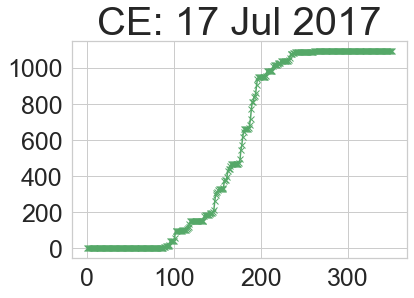

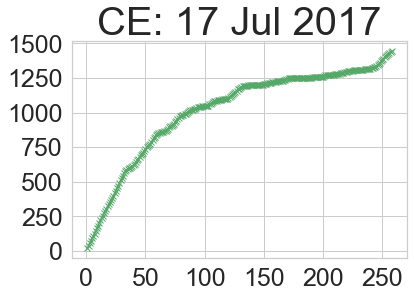

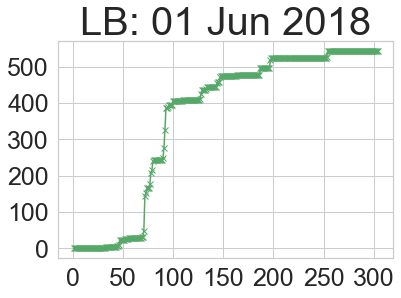

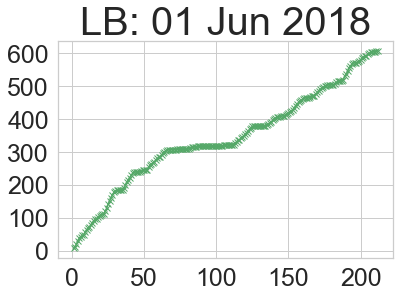

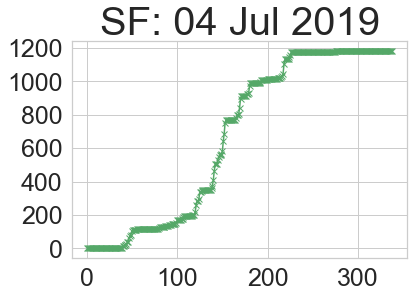

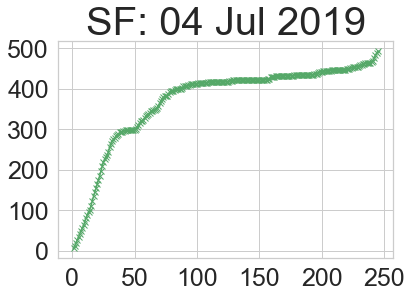

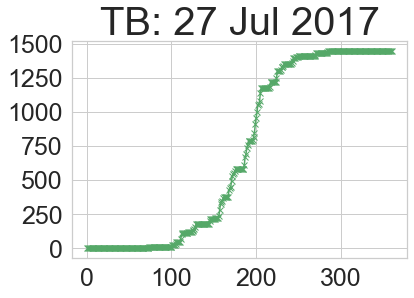

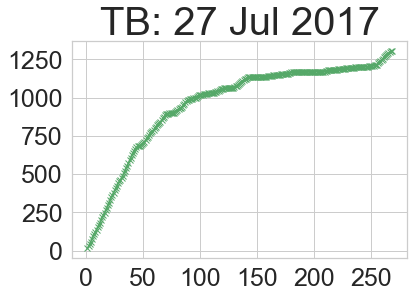

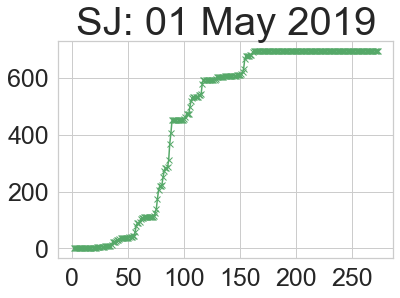

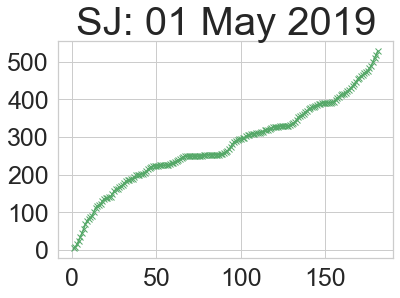

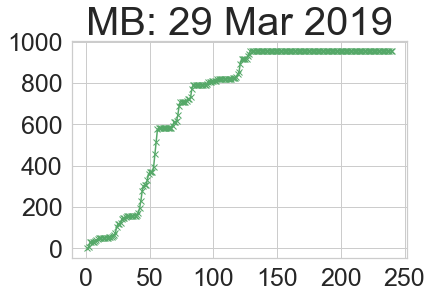

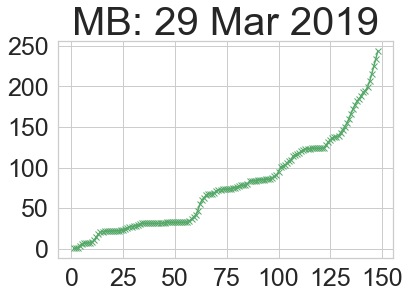

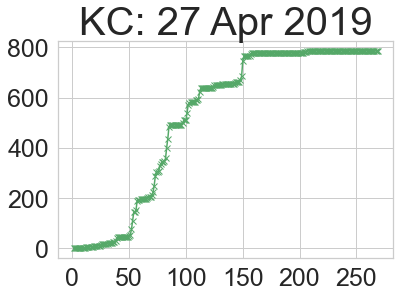

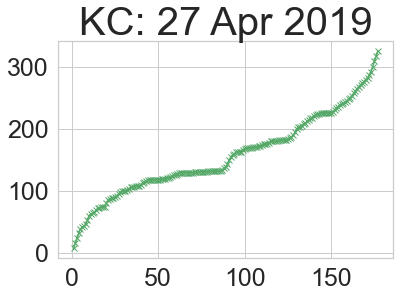

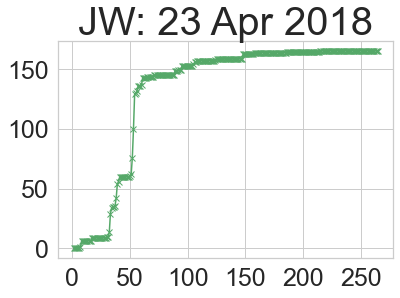

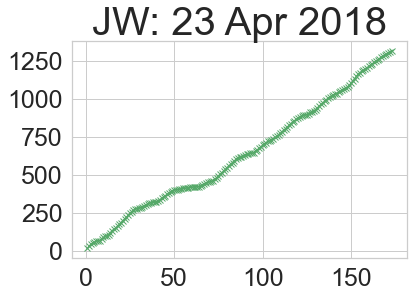

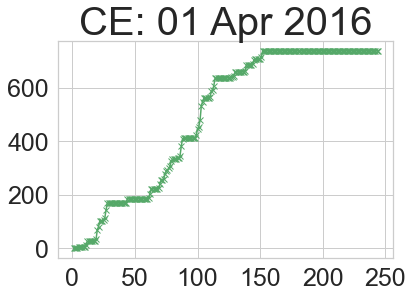

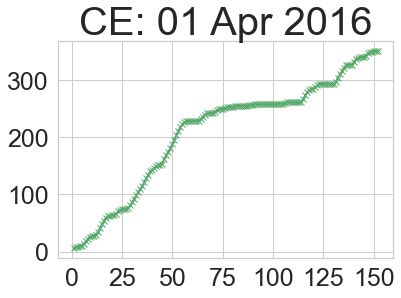

In [ ]:
ASO = ['Translated_Rescaled_800MReprojectedASO_50M_SWE_USCACE_20170717.tif', 'Translated_Rescaled_800MReprojectedASO_50M_SWE_USCALB_20180601.tif', 'Translated_Rescaled_800MReprojectedASO_50M_SWE_USCASF_20190704.tif', 'Translated_Rescaled_800MReprojectedASO_50M_SWE_USCATB_20170727.tif', 'Translated_Rescaled_800MReprojectedASO_50M_SWE_USCASJ_20190501.tif', 'Translated_Rescaled_800MReprojectedASO_50M_SWE_USCAMB_20190329.tif', 'Translated_Rescaled_800MReprojectedASO_50M_SWE_USCAKC_20190427.tif', 'Translated_Rescaled_800MReprojectedASO_50M_SWE_USCAJW_20180423.tif', 'Translated_Rescaled_800MReprojectedASO_50M_SWE_USCACE_20160401.tif']
for ASO_file in ASO:
    #1. PRISM_FILE PATHS
    PRISM_PPT_folder_path = '/Users/lamaelhalabi/Documents/research Berekely /Lamas processing code/California Maps and generated data/My generated Data/800M/Prism_data/PPT_ASO_California_PRISM800'
    PRISM_TAVG_folder_path = '/Users/lamaelhalabi/Documents/research Berekely /Lamas processing code/California Maps and generated data/My generated Data/800M/Prism_data/TAVG_ASO_California_PRISM800'

    #2.  ASO DATE : From ASO_file string and ASO indicator
    ASO_date_str = ASO_file.split('_')[6]
    ASO_date_str = ASO_date_str[: 8]
    ASO_str_indicator = ASO_file.split('_')[5] + ASO_file.split('_')[6]
    ASO_str_indicator = ASO_str_indicator[4: 14]
    ASO_date = datetime.datetime.strptime(ASO_date_str,"%Y%m%d")
    title = f'{basin}: {ASO_date .strftime("%d %b %Y")}'

    #3. GET Lat and Long for ASO File
    Points_gdf = get_ASO_Points_gdf(ASO_file)

    #4.0 Accumulated snow
    start_date_snow = datetime.datetime(ASO_date.year-1, 8, 1) # Start date = August 1 of the previous year
    number_of_days_snow = (ASO_date - start_date_snow).days + 1

    #4.1 Prism get PTT and TAVG
    PRISM_PPT_df = get_PRISM_PPT_df(number_of_days_snow, PRISM_PPT_folder_path, ASO_date, Points_gdf)
    PRISM_TAVG_df = get_PRISM_TAVG_df(number_of_days_snow, PRISM_TAVG_folder_path, ASO_date, Points_gdf)

    #4.2 GET PRISM_SNOW Dataframe
    PRISM_snow_df = PRISM_PPT_df.copy(deep=True)
    PRISM_snow_df.where(PRISM_TAVG_df <= 0.0, other=0.0, inplace=True)

    #4.3 Get Mean Accumulated snow
    mean_accum_snow = [np.mean(np.sum(PRISM_snow_df.iloc[:,:n_days], axis=1)) for n_days in range(1, number_of_days_snow)]

    #4.4 Plot Accumulated Snow
    plt.xlabel('')
    plt.ylabel('')
    locs, labels = plt.xticks()
    plt.setp(labels, fontsize = 25)
    locs, labels = plt.yticks()
    plt.setp(labels, fontsize = 25)
    plt.plot(range(1, number_of_days_snow), mean_accum_snow, '-xC2')
    plt.title(title, fontsize = 40)
    plt.savefig(ASO_str_indicator+ 'Snow.png', bbox_inches = 'tight')
    plt.show()

    #5.0 Sum PDD
    start_date_PDD = datetime.datetime(ASO_date.year-1, 11, 1) # Start date = November 1 of the previous year
    number_of_days_PDD= (ASO_date - start_date_PDD).days + 1

    #5.1 Prism get PTT and TAVG
    PRISM_PPT_df = get_PRISM_PPT_df(number_of_days_PDD, PRISM_PPT_folder_path, ASO_date, Points_gdf)
    PRISM_TAVG_df = get_PRISM_TAVG_df(number_of_days_PDD, PRISM_TAVG_folder_path, ASO_date, Points_gdf)

    #5.2 Get PRISM_PDD Dataframe
    Prism_PDD_df = PRISM_TAVG_df.iloc[:,:number_of_days_PDD].where(PRISM_TAVG_df.iloc[:,:number_of_days_PDD] > 0.0, other=0.0)

    #5.3 Get SUM PDD
    SUM_PDD = [np.mean(np.sum(Prism_PDD_df.iloc[:,:n_days], axis=1)) for n_days in range(1, number_of_days_PDD)]

    #5.4 Plot SUM PDD
    plt.xlabel('')
    plt.ylabel('')
    locs, labels = plt.xticks()
    plt.setp(labels, fontsize = 25)
    locs, labels = plt.yticks()
    plt.setp(labels, fontsize = 25)
    plt.plot(range(1, number_of_days_PDD), SUM_PDD, '-xC2')
    plt.title(title, fontsize = 40)
    plt.savefig( ASO_str_indicator+ 'PDD.png', bbox_inches = 'tight')
    plt.show()

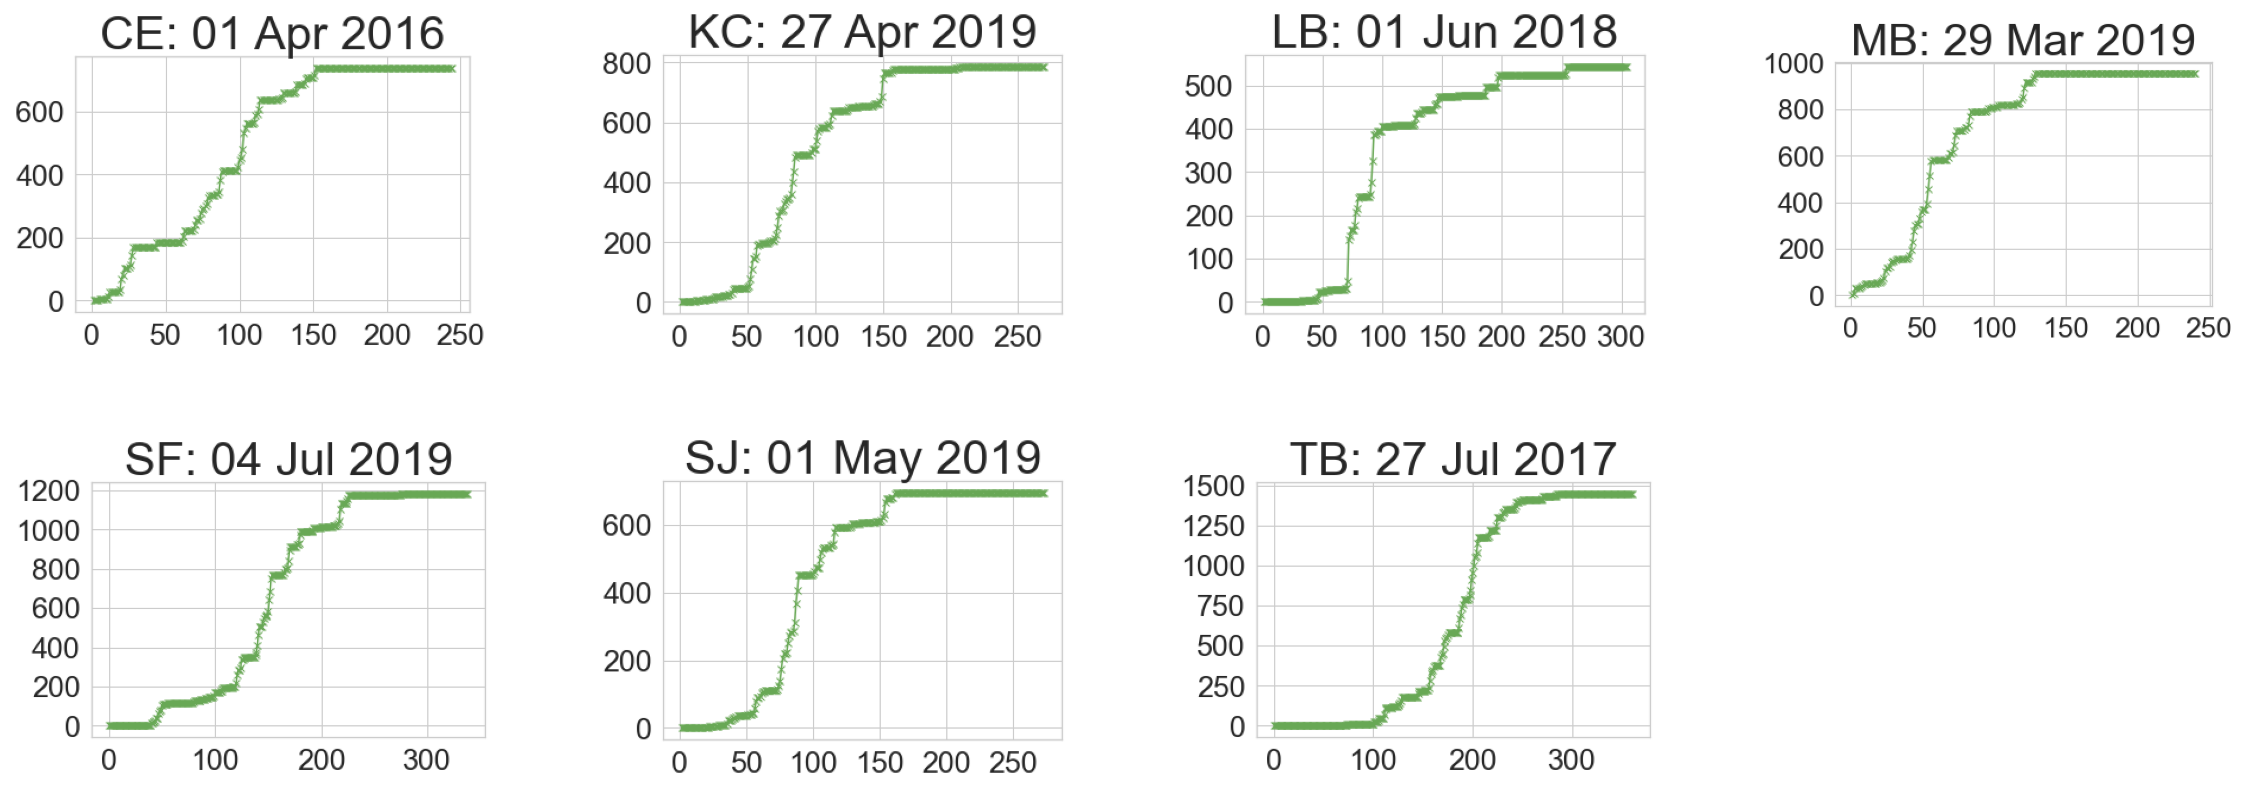

In [ ]:

# code for displaying multiple images in one figure

#import libraries
import cv2
from matplotlib import pyplot as plt

# create figure
fig = plt.figure(figsize=(40, 30))

# setting values to rows and column variables
rows = 4
columns = 4

# reading images
Image1 = cv2.imread('CE20160401Snow.png')
Image3 = cv2.imread('KC20190427Snow.png')
Image4 = cv2.imread('LB20180601Snow.png')
Image5 = cv2.imread('MB20190329Snow.png')
Image6 = cv2.imread('SF20190704Snow.png')
Image7 = cv2.imread('SJ20190501Snow.png')
Image8 = cv2.imread('TB20170727Snow.png')
Images = [Image1, Image3, Image4, Image5, Image6, Image7, Image8]
index = 1

for image in Images:

    # Adds a subplot at the 1st position
    fig.add_subplot(rows, columns, index)

    # showing image
    plt.imshow(image)
    plt.axis('off')
    index += 1

plt.savefig('AccumulatedSnowfall.png', bbox_inches = 'tight')



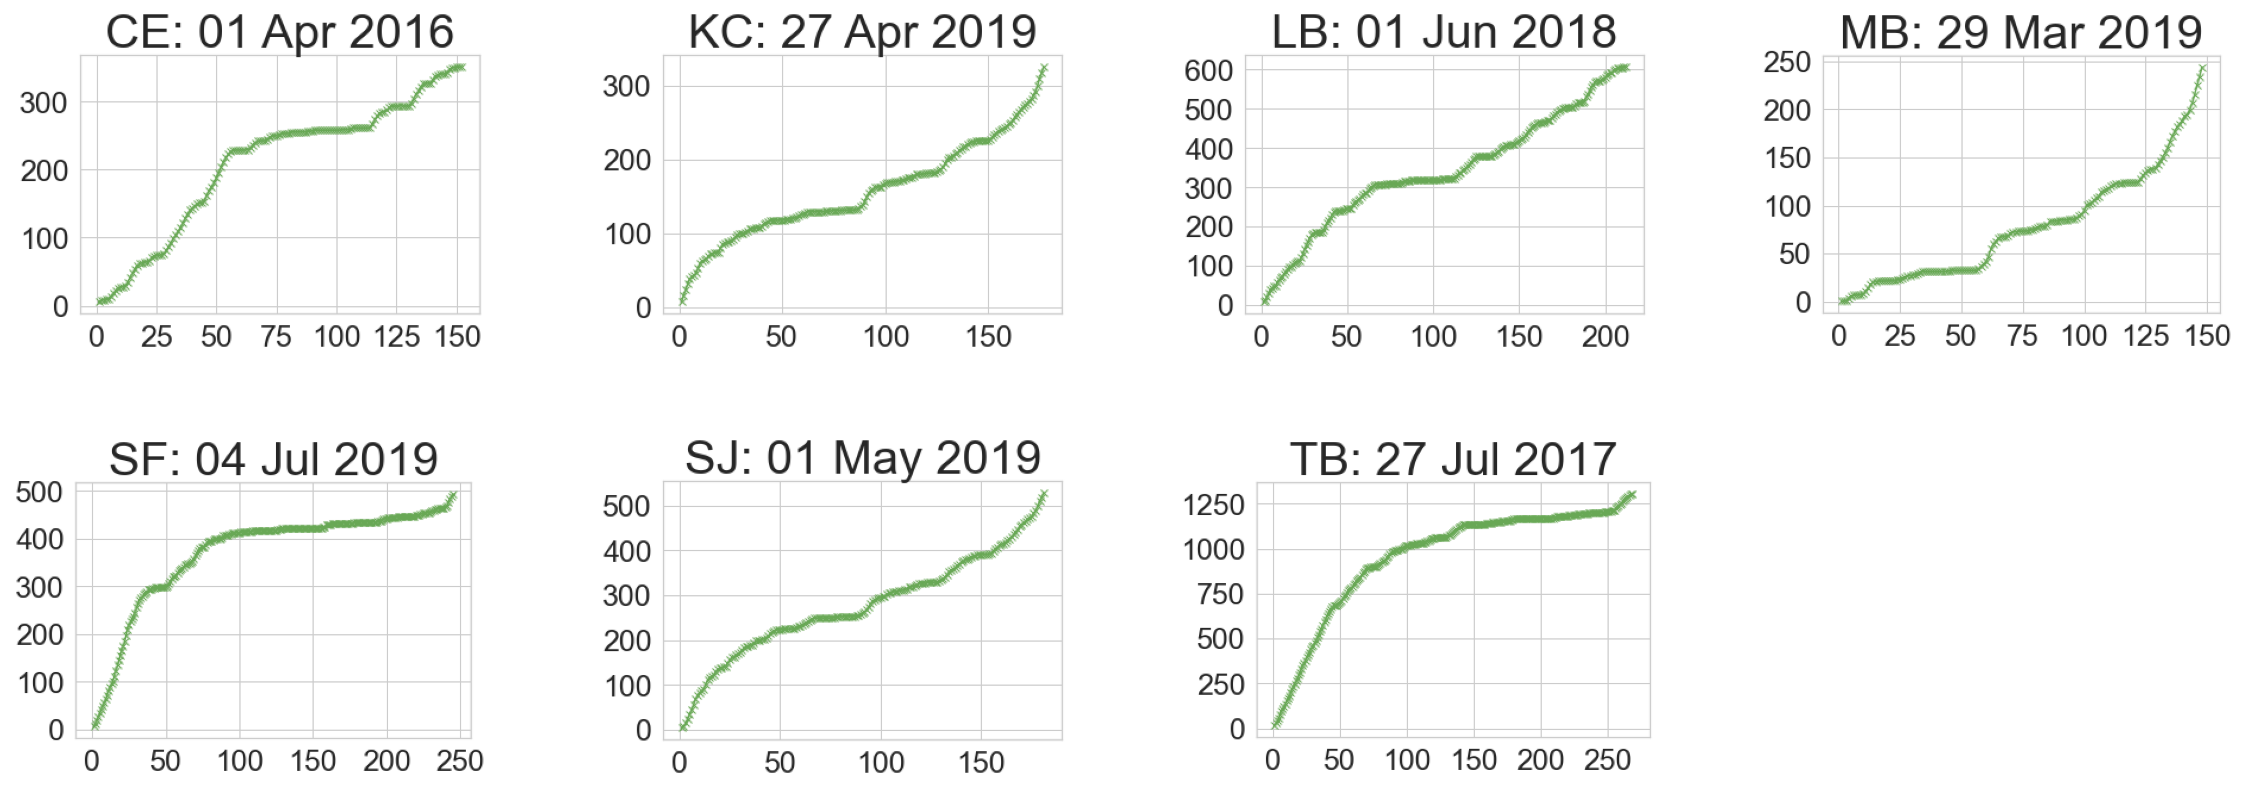

In [ ]:

# code for displaying multiple images in one figure

#import libraries
import cv2
from matplotlib import pyplot as plt

# create figure
fig = plt.figure(figsize=(40, 30))

# setting values to rows and column variables
rows = 4
columns = 4

# reading images
Image1 = cv2.imread('CE20160401PDD.png')
Image3 = cv2.imread('KC20190427PDD.png')
Image4 = cv2.imread('LB20180601PDD.png')
Image5 = cv2.imread('MB20190329PDD.png')
Image6 = cv2.imread('SF20190704PDD.png')
Image7 = cv2.imread('SJ20190501PDD.png')
Image8 = cv2.imread('TB20170727PDD.png')
Images = [Image1, Image3, Image4, Image5, Image6, Image7, Image8]
index = 1

for image in Images:

    # Adds a subplot at the 1st position
    fig.add_subplot(rows, columns, index)

    # showing image
    plt.imshow(image)
    plt.axis('off')
    index += 1

plt.savefig('SUMPDD.png', bbox_inches = 'tight')


